# Testando Modelos Locais

Antes de definirmos qual modelo utilizar em nosso software, decidimos, como primeiro passo, testar modelos open-source disponíveis. O objetivo foi compreender melhor a dinâmica desses modelos e sua aplicabilidade em diferentes cenários. Para isso, criamos um benchmark abrangente, avaliando uma série de modelos com diferentes quantidades de parâmetros, tipos de questões e analisando seu desempenho em diversas disciplinas.

In [1]:
from IPython.display import display, clear_output
import os

if "notebooks" in os.getcwd():
    os.chdir(os.path.abspath(os.path.join(os.getcwd(), "..")))

import lib.utils
from lib.utils import plots
from lib.models_help.runner import test_models

import random
random.seed(42)

import warnings
warnings.filterwarnings("ignore")

questoes = lib.utils.load_json("./data/questoes/questoes.json")

## 1. Modelos

Inicialmente, exploramos modelos disponíveis no [Ollama](https://ollama.com/), um repositório de LLMs similar ao Hugging Face, mas que permite uma facilidade no download e interface de comunicação com as LLMs. Optamos por baixar localmente **20 modelos**, variando em quantidade de parâmetros e especialização, incluindo modelos com capacidade maior de auto-avaliação ou raciocínio (*reasoning*), multi-modais (*vision*), matemática (*math*) e modelos mais comuns limitados a apenas texto (*text*).

Ao selecionar os modelos, consideramos uma limitação fundamental: o **tamanho máximo de 14 GB**. Como o objetivo é emular um produto destinado a **clientes** e não a servidores de alta performance, priorizamos modelos compactos que possam ser **executados em dispositivos locais**, sem depender de infraestrutura robusta. Vale lembrar que **o tamanho de um modelo não se resume ao espaço ocupado pelos arquivos armazenados**, mas também ao consumo de memória durante a execução, sendo carregado integralmente na RAM e/ou VRAM do dispositivo do usuário.

Abaixo, apresentamos uma análise da relação entre a quantidade de parâmetros (em bilhões) e o tamanho dos modelos (em GB).


| #   | Modelo            | Parâmetros                                   | Tamanho (Em GB)               | Algoritmo   |
|-----|-------------------|----------------------------------------------|-------------------------------|-------------|
| 1   | deepseek-r1       | `7.0`                                        | `7.0`                         | reasoning   |
| 2   | deepscaler        | `1.5`                                        | `3.6`                         | reasoning   |
| 3   | gemma2            | `9.0`                                        | `5.4`                         | text        |
| 4   | llava             | `7.0`                                        | `4.7`                         | vision      |
| 5   | llava-llama3      | `8.0`                                        | `5.5`                         | vision      |
| 6   | llava-phi3        | `3.8`                                        | `2.9`                         | vision      |
| 7   | llama3.2          | `3.0`                                        | `2.0`                         | text        |
| 8   | llama3.2-vision   | `11.0`                                       | `7.9`                         | vision      |
| 9   | mathstral         | `7.0`                                        | `4.1`                         | math        |
| 10  | minicpm-v         | `8.0`                                        | `5.5`                         | vision      |
| 11  | mistral           | `7.0`                                        | `4.1`                         | text        |
| 12  | mistral-nemo      | `12.0`                                       | `7.1`                         | reasoning   |
| 13  | mistral-small     | `24.0`                                       | `14.0`                        | text        |
| 14  | moondream         | `1.8`                                        | `1.7`                         | vision      |
| 15  | openthinker       | `7.0`                                        | `4.7`                         | reasoning   |
| 16  | phi3.5            | `3.8`                                        | `2.2`                         | reasoning   |
| 17  | phi4              | `14.0`                                       | `9.1`                         | text        |
| 18  | qwen2-math        | `7.0`, `1.5`                                 | `4.4`, `0.934`                | math        |
| 19  | qwen2.5           | `14.0`, `7.0`, `1.5`                         | `9.0`, `4.7`, `0.986`         | text        |
| 20  | smallthinker      | `3.0`                                        | `3.6`                         | reasoning   |


A imagem abaixo ilustra a correlação entre o número de parâmetros (em bilhões) e o tamanho dos modelos (em GB):

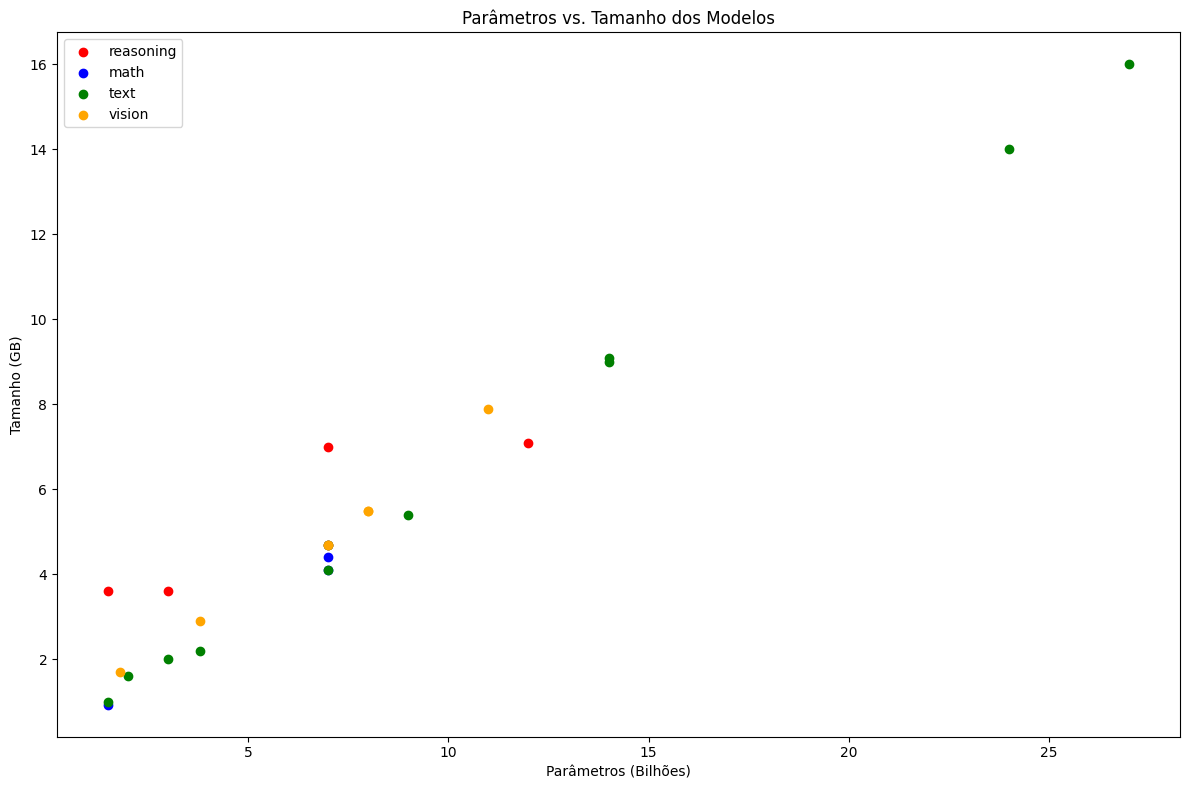

In [2]:
lib.utils.models_info.plot_parameters_x_size()
None

Observamos que, de maneira geral, **a relação entre a quantidade de parâmetros e o tamanho do modelo segue um padrão bastante linear**. No entanto, há algumas diferenças dependendo do tipo de modelo:  

- **Modelos de reasoning** tendem a ser **ligeiramente maiores** do que outros modelos com a mesma quantidade de parâmetros.  
- **Modelos de visão computacional (vision)** também apresentam um **aumento sutil no tamanho**, possivelmente devido às camadas especializadas para processamento de imagens.  

Essa análise inicial nos permite compreender melhor as exigências de cada modelo em termos de armazenamento e memória, ajudando na escolha da melhor opção para diferentes aplicações locais.

## 2. Questões de Texto  

O primeiro tipo de questão que vamos analisar são as **questões de texto**, que representam **63,6%** de todas as questões do dataset. Para avaliar o desempenho dos modelos nesse tipo de tarefa, dividimos os testes em **três grupos distintos**:  

1. **Modelos com diferentes versões de tokens** – investigamos o impacto do tamanho do modelo no desempenho, comparando versões de um mesmo modelo com quantidades variadas de tokens.  
2. **Modelos com suporte a reasoning** – testamos modelos projetados para raciocínio avançado, que, apesar de mais lentos, prometem um processamento mais elaborado e preciso.  
3. **Demais modelos baseados apenas em texto** – avaliamos modelos que lidam exclusivamente com entrada textual, sem otimizações específicas para reasoning.  

Para conduzir esse experimento, selecionamos **100 questões de forma pseudo-aleatória**, garantindo uma distribuição balanceada com **25 questões de cada disciplina**. Dessa forma, buscamos assegurar que os resultados reflitam de maneira justa a capacidade dos modelos em interpretar e responder diferentes tipos de perguntas textuais.  


In [3]:
# Realizamos uma filtragem nas questões para obtermos apenas as questões com apenas texto
text_questions   = list(filter(lambda x : x["type"] == "only-text", questoes))

# Agora seelcionamos de forma pseudo-aleatória as 100 questões, sendo 25 de cada disciplina
example_text_questions  = (
    list(random.sample(list(filter(lambda x : x["discipline"] == "ciencias-humanas", text_questions)), 25)) +
    list(random.sample(list(filter(lambda x : x["discipline"] == "ciencias-natureza", text_questions)),25)) +
    list(random.sample(list(filter(lambda x : x["discipline"] == "linguagens", text_questions)),25)) +
    list(random.sample(list(filter(lambda x : x["discipline"] == "matematica", text_questions)),25))
)

### 2.1 Avaliando o Impacto do Tamanho do Modelo  

Para esse teste, utilizaremos **dois modelos principais**:  

- **Qwen2.5**, nas versões:  
  - `14b` (9.0GB)  
  - `7b` (4.7GB)  
  - `1.5b` (1.9GB)  

- **Gemma2**, nas versões:  
  - `27b` (16GB)  
  - `9b` (5.4GB)  
  - `2b` (1.6GB)  

Escolhemos esses dois modelos porque, entre os selecionados, são os que oferecem **maior diversidade de quantidade de parâmetros**, permitindo uma análise mais abrangente. Além disso, eles apresentam uma variação de tamanho que cobre desde **modelos extremamente compactos** (menos de 2GB, ideais para sistemas embarcados) até **modelos mais convencionais** (`7b` e `9b`), além de **opções mais robustas**, como o `14b` e `27b`.  

Para esse experimento, utilizaremos o mesmo **conjunto de questões selecionadas de forma pseudo-aleatória**, já descrito anteriormente. Avaliaremos:  

- **Métricas de desempenho**, incluindo número de acertos e erros, tanto no geral quanto por disciplina.  
- **Comparação entre os dois modelos**, buscando identificar **tendências de eficiência** em relação à quantidade de parâmetros.  

Nosso objetivo final é tentar inferir **até que ponto o aumento no número de parâmetros impacta o desempenho** e se há um ponto de equilíbrio entre **qualidade da resposta e eficiência computacional**.  


#### 2.1.1 - Qwen2.5  

Nosso primeiro alvo de análise é o **Qwen 2.5**, avaliando seu desempenho em diferentes tamanhos e identificando padrões de comportamento.  

##### **Acurácia dos Modelos**  

Ao analisarmos a **acurácia**, percebemos que **o número de acertos se manteve estável** entre o modelo mais robusto e o modelo intermediário. No entanto, ao compararmos com a versão mais leve, observamos uma **queda significativa**, reduzindo-se para **menos da metade** da acurácia dos demais modelos.  

##### **Tempo de Execução**  

O mesmo padrão foi identificado em relação ao **tempo de execução**. O modelo intermediário apresentou **tempos máximos semelhantes ao modelo maior**, enquanto o modelo mais leve teve uma redução proporcional no tempo de inferência. Além disso, ao analisarmos os tempos médios, identificamos uma **relação linear entre a quantidade de parâmetros e o tempo de execução** – quanto menor o número de parâmetros, menor tende a ser o tempo necessário para processar uma resposta.  

##### **Desempenho por Disciplina**  

Ao compararmos o desempenho por disciplina, observamos que a **diferença entre o modelo intermediário e o modelo maior foi mínima**, exceto por um leve aumento na acurácia em **ciências humanas** no modelo maior. Em **matemática**, ambos os modelos apresentaram **o mesmo desempenho**, sem vantagens claras entre eles.  

Um padrão recorrente em **todos os tamanhos do Qwen 2.5** foi a **baixa acurácia em questões matemáticas**, o que sugere uma limitação específica do modelo nessa área. Esse comportamento também foi observado em outros modelos, indicando que pode ser uma característica comum entre os LLMs testados.  

##### **Visualização dos Resultados**  

Os gráficos abaixo ilustram esses padrões. Caso esteja acessando via plataforma interativa, você pode **selecionar os modelos e o tipo de gráfico** para comparação personalizada.


,Model,Size,Finish,OK,Null,Tout,Err,Acc,Prec,Ttot,TTout,Tle,Tavg,Tmax,Tmin
0,qwen2.5:14b,9.0,100 (33.3%),64,2,0,34,0.640000,0.653061,01:12,01:12,0.00,0.72,4.78,0.30
1,qwen2.5:7b,4.7,100 (33.3%),64,0,0,36,0.640000,0.640000,33.26,33.26,0.00,0.33,4.68,0.15
2,qwen2.5:1.5b,1.0,100 (33.3%),42,0,0,58,0.420000,0.420000,15.78,15.78,0.00,0.16,2.12,0.07
3,TOTAL,14.7,300 (33.3%),170,2,0,128,0.566667,0.570470,02:01,02:01,0.00,0.40,4.78,0.07


['qwen2.5:14b', 'qwen2.5:7b', 'qwen2.5:1.5b']
A função foi alterada!
{'2011013-qwen2.5:14b': {'question': '2011013', 'model': 'qwen2.5:14b', 'response': '(A)', 'response_length': 3, 'answer': 'A', 'correct': True, 'time': 4.0853456, 'discipline': 'ciencias-humanas', 'timeout': None}, '2009066-qwen2.5:14b': {'question': '2009066', 'model': 'qwen2.5:14b', 'response': '(E)', 'response_length': 3, 'answer': 'E', 'correct': True, 'time': 0.7758534, 'discipline': 'ciencias-humanas', 'timeout': None}, '2015026-qwen2.5:14b': {'question': '2015026', 'model': 'qwen2.5:14b', 'response': '(A)', 'response_length': 3, 'answer': 'A', 'correct': True, 'time': 0.4603151, 'discipline': 'ciencias-humanas', 'timeout': None}, '2014032-qwen2.5:14b': {'question': '2014032', 'model': 'qwen2.5:14b', 'response': '(D)', 'response_length': 3, 'answer': 'D', 'correct': True, 'time': 0.5788113, 'discipline': 'ciencias-humanas', 'timeout': None}, '2013088-qwen2.5:14b': {'question': '2013088', 'model': 'qwen2.5:14b',

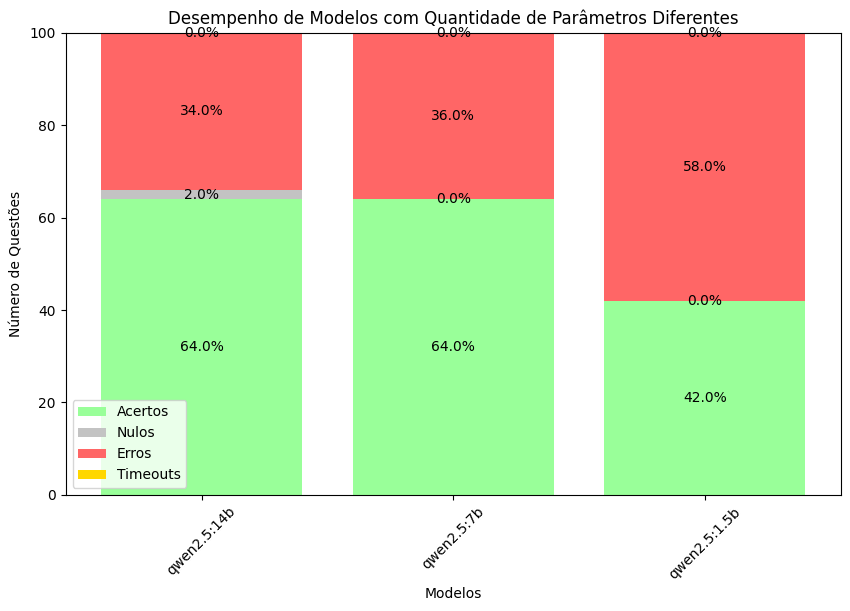

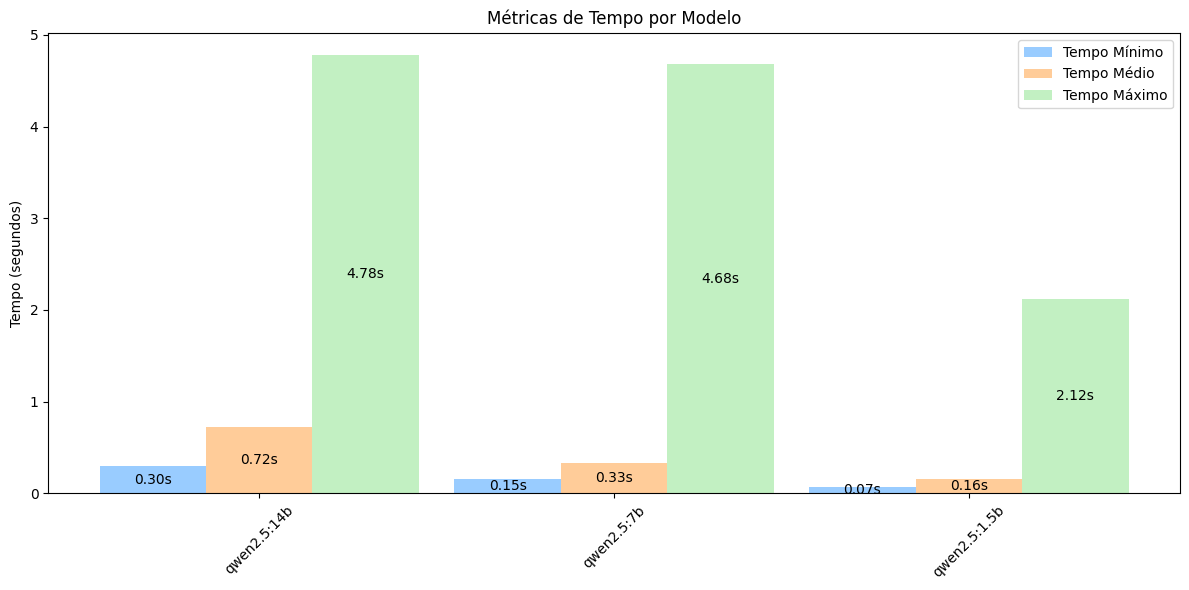

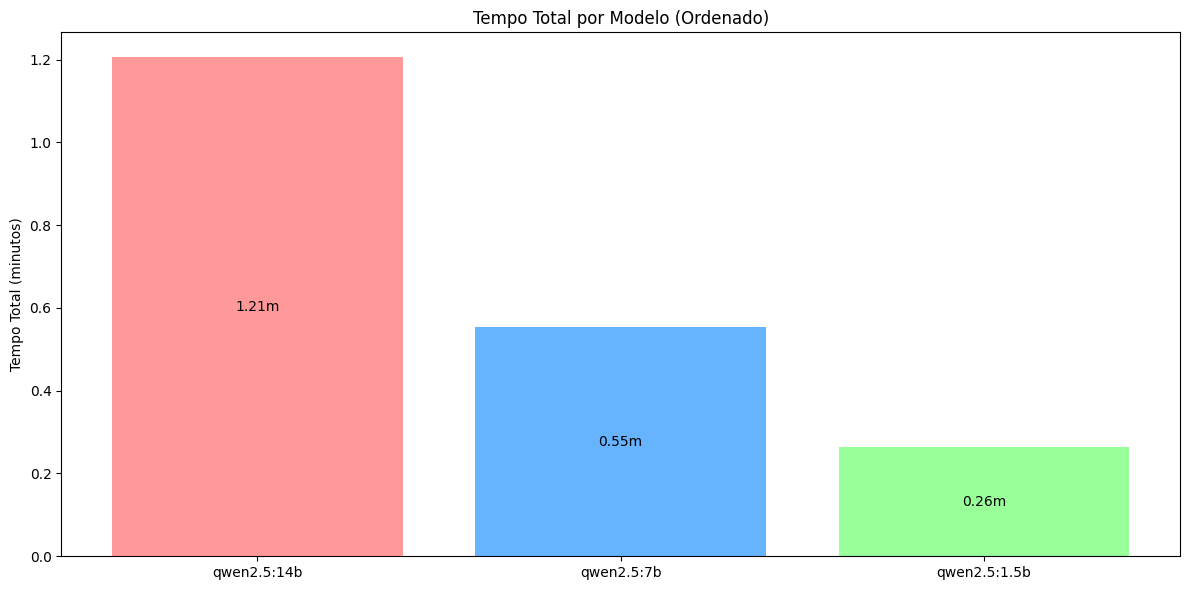

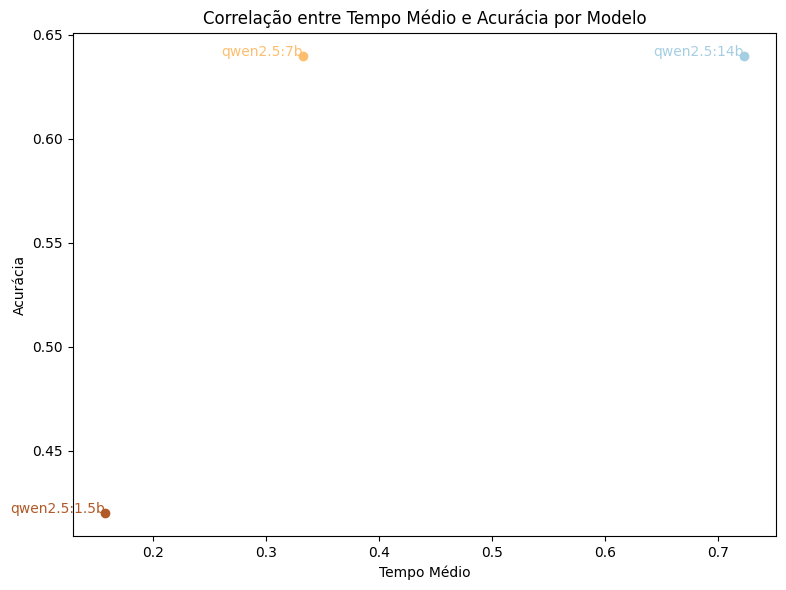

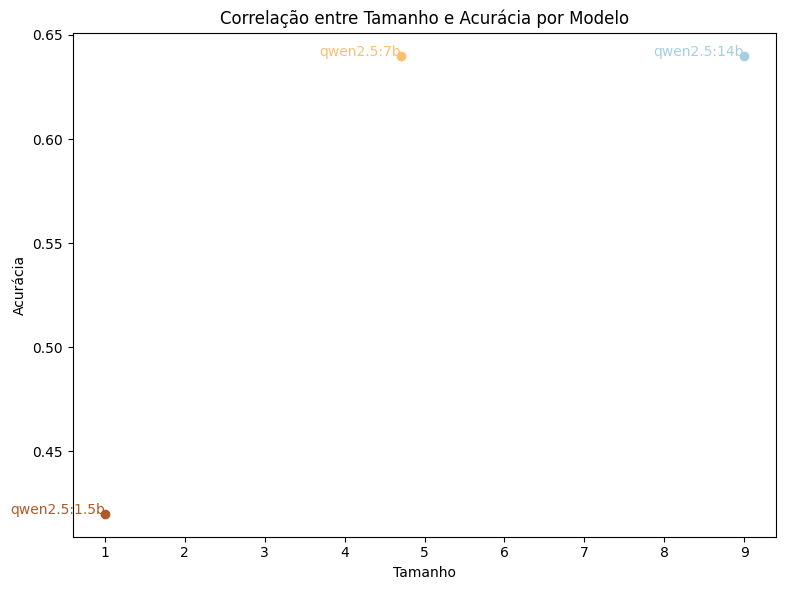

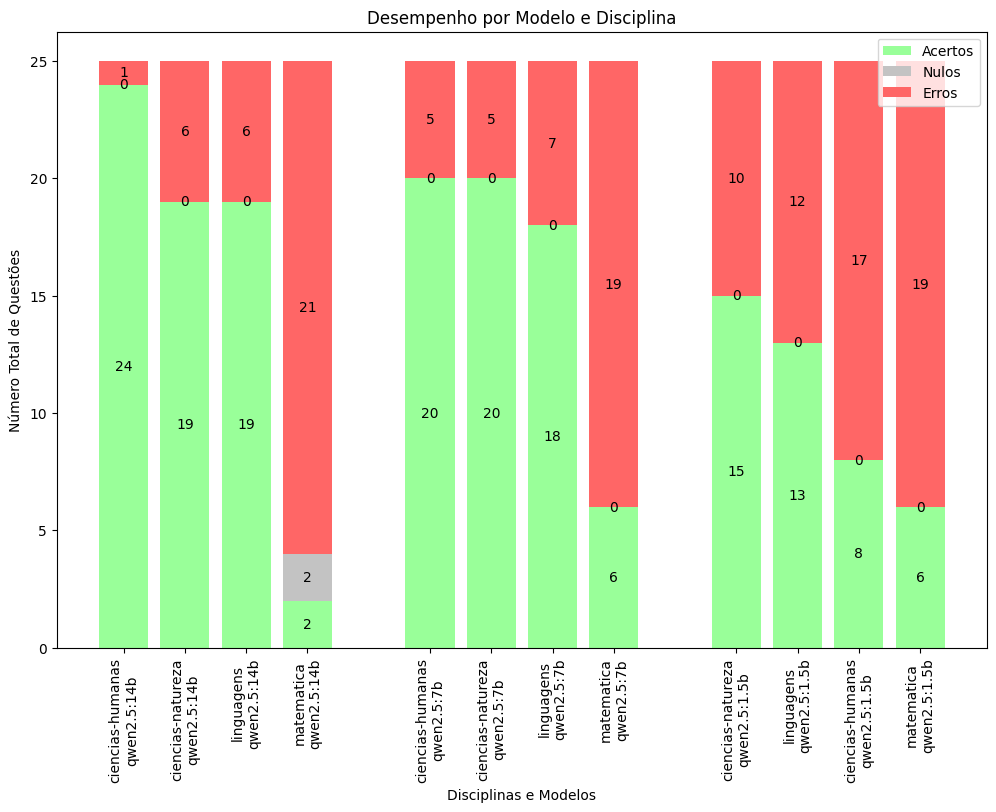

In [4]:
qwen_models = ["qwen2.5:14b", "qwen2.5:7b", "qwen2.5:1.5b"]

test_result = test_models(
    primary_models=qwen_models,
    questions=example_text_questions
)

qwen_table = lib.utils.test_table(
    questions=example_text_questions,
    models=qwen_models
)

clear_output(wait=True)
display(lib.utils.format_test_table(qwen_table))
plots.model_performance(qwen_table, "Desempenho de Modelos com Quantidade de Parâmetros Diferentes")
plots.time_metrics(qwen_table)
plots.time_metrics_total(qwen_table)
plots.correlation(qwen_table)
plots.correlation(qwen_table, "Size")
plots.discipline_performance(qwen_models, example_text_questions, True, False)
None

#### 2.1.3 - Gemma2  

Nesta seção, analisamos o desempenho do modelo **Gemma2** em diferentes configurações de tamanho, a fim de identificar padrões de comportamento e avaliar sua eficiência em relação à acurácia e ao tempo de execução.  

##### **Acurácia dos Modelos**  

A análise da **acurácia** revelou que, de maneira similar aos modelos **Qwen2.5**, a quantidade de acertos obtida pelo modelo mais robusto e pelo modelo intermediário permaneceu praticamente inalterada. No entanto, ao comparar com o modelo de menor porte, observou-se uma redução no número de respostas corretas.  

Diferentemente do que foi constatado no **Qwen2.5**, a perda de desempenho no modelo mais leve do **Gemma2** foi **menos acentuada**. A diferença observada foi de **apenas 10 respostas corretas a menos em relação ao modelo intermediário**, representando uma das melhores relações entre **desempenho e tamanho do modelo** entre os modelos avaliados.  

##### **Tempo de Execução**  

Em relação ao **tempo de inferência**, os resultados obtidos não seguiram a correlação linear observada em outros modelos. O **modelo intermediário apresentou o menor tempo médio e mínimo de execução**, o que diverge da expectativa de um comportamento proporcional ao número de parâmetros. Esse fenômeno sugere que o **Gemma2 pode possuir otimizações internas**, que resultam em um melhor aproveitamento computacional em determinados tamanhos.  

##### **Desempenho por Disciplina**  

A análise do desempenho por disciplina revelou uma **intercalação entre os modelos quanto à sua eficácia em diferentes áreas do conhecimento**:  

- **Ciências humanas** – Desempenho equivalente entre os modelos maiores, o menor ainda sim conseguiu uma quantidade de acertos aceitáveis, variando em apenas 2 questões.  
- **Ciências naturais e matemática** – O modelo mais robusto apresentou um desempenho superior, com um aumento de **3 e 2 respostas corretas**, respectivamente.  
- **Linguagens** – O modelo intermediário superou o modelo mais robusto, obtendo **4 respostas corretas adicionais**.  

Embora a **acurácia geral tenha se mantido semelhante entre os modelos**, a análise segmentada por disciplina evidencia que **o desempenho dos modelos não é uniforme** e pode variar conforme o domínio da questão analisada.  

##### **Desempenho em Matemática**  

O padrão de **baixo desempenho em matemática** também foi identificado no modelo **Gemma2**, confirmando a tendência observada em outros modelos. Especificamente, os resultados foram:  

- **Modelo robusto** – 7 acertos  
- **Modelo intermediário** – 5 acertos  
- **Modelo leve** – 4 acertos  

Independentemente da configuração utilizada, o desempenho em matemática manteve-se reduzido, o que sugere uma **limitação inerente ao modelo** no processamento desse tipo específico de questão.  

##### **Visualização dos Resultados**  

As informações detalhadas podem ser observadas nos gráficos apresentados a seguir. Além disso, caso o leitor esteja acessando por meio da plataforma interativa, é possível **selecionar os modelos e o tipo de gráfico desejado** para uma análise comparativa personalizada.  


,Model,Size,Finish,OK,Null,Tout,Err,Acc,Prec,Ttot,TTout,Tle,Tavg,Tmax,Tmin
0,gemma2:27b,16.0,100 (33.3%),69,1,0,30,0.69,0.696970,12:08,12:08,0.00,7.29,01:20,5.78
1,gemma2,5.4,100 (33.3%),68,1,0,31,0.68,0.686869,58.63,58.63,0.00,0.59,8.83,0.28
2,gemma2:2b,1.6,100 (33.3%),58,0,0,42,0.58,0.580000,06:32,06:32,0.00,3.93,6.44,3.59
3,TOTAL,23.0,300 (33.3%),195,2,0,103,0.65,0.654362,19:40,19:40,0.00,3.93,01:20,0.28


['gemma2:2b', 'gemma2', 'gemma2:27b']
A função foi alterada!
{'2009161-gemma2': {'question': '2009161', 'model': 'gemma2', 'response': '(C) \n', 'answer': 'C', 'correct': False, 'time': 0.4675673, 'response_length': 5, 'discipline': 'matematica', 'timeout': None}, '2009175-gemma2': {'question': '2009175', 'model': 'gemma2', 'response': "(C) \n\n\nHere's how to solve the problem:\n\n**Let's use the given information and formulas:**\n\n* **ICadÚnico = (TC + TA) / 2**\n* **TC = NV / NF**\n* **TA = NA / NV**\n\n* We know IcadÚnico = 0.6 when NF is its original value.\n* Doubling NF makes the IcadÚnico fall to 0.5.  We can set up equations based on these scenarios.\n\n**Setting up the equations:**\n\n1. **Initial situation (Original NF):**\n   0.6 = (NV / NF + NA / NV) / 2\n\n2. **New situation (Doubled NF):**\n   0.5 = (NV / (2 * NF) + NA / NV) / 2\n\n* We also know that **NA + NV = 3600**.\n\n**Solving for NF:**\n\nThe problem involves solving a system of equations. This can be complex, b

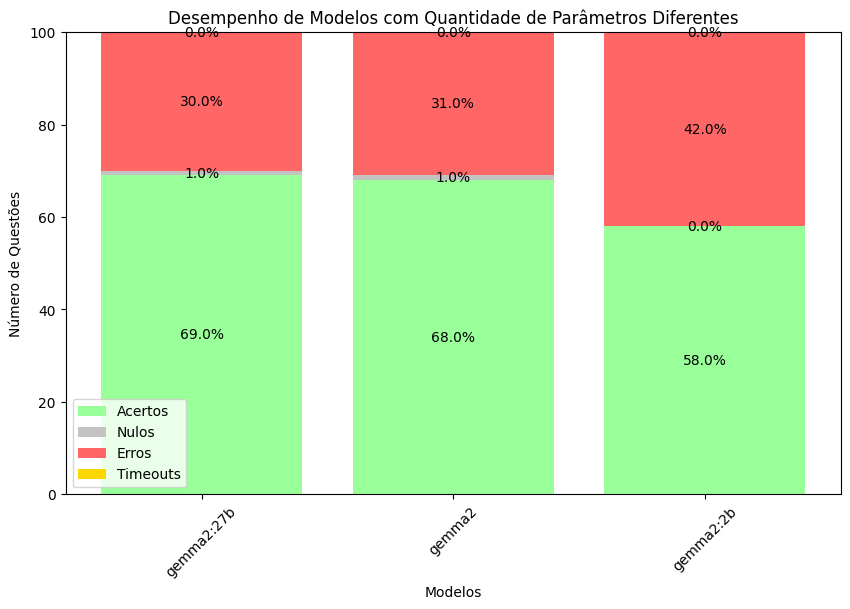

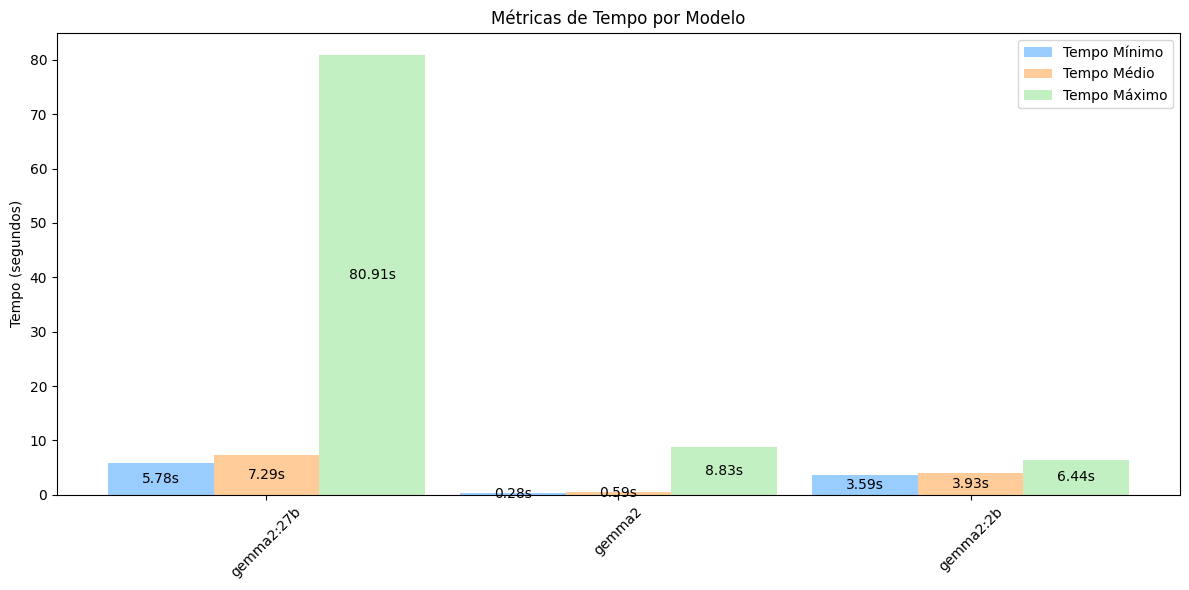

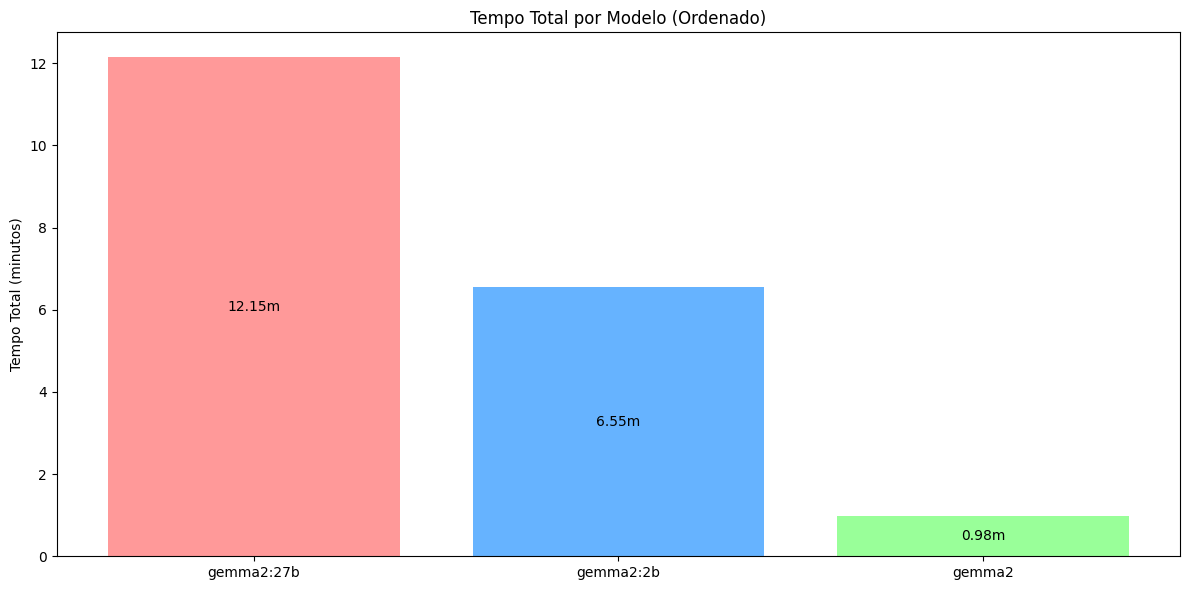

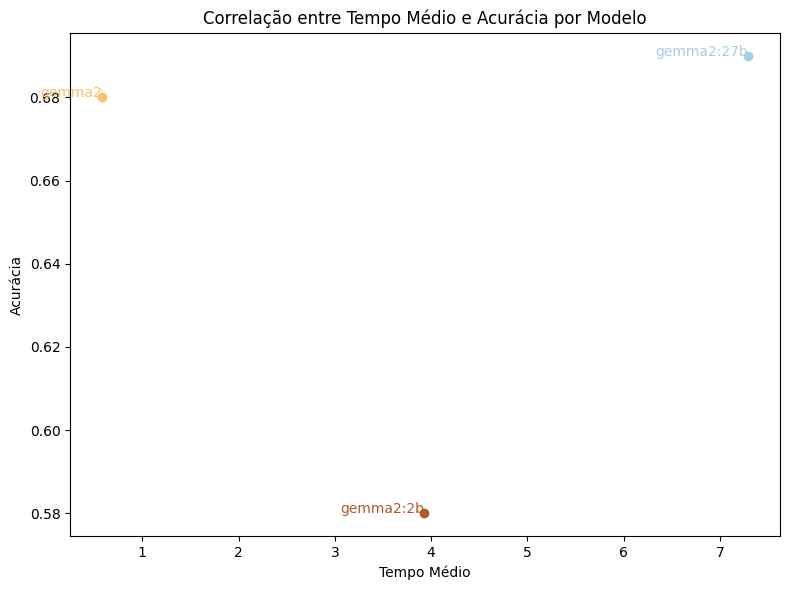

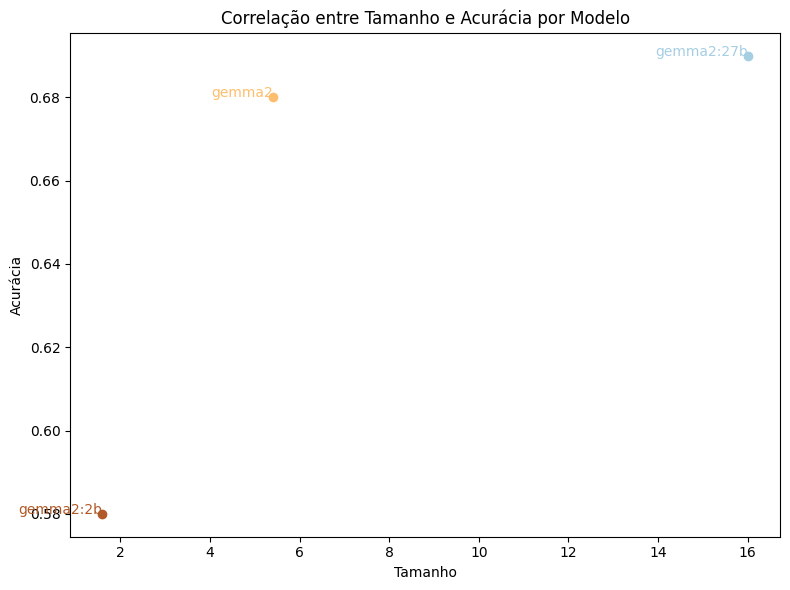

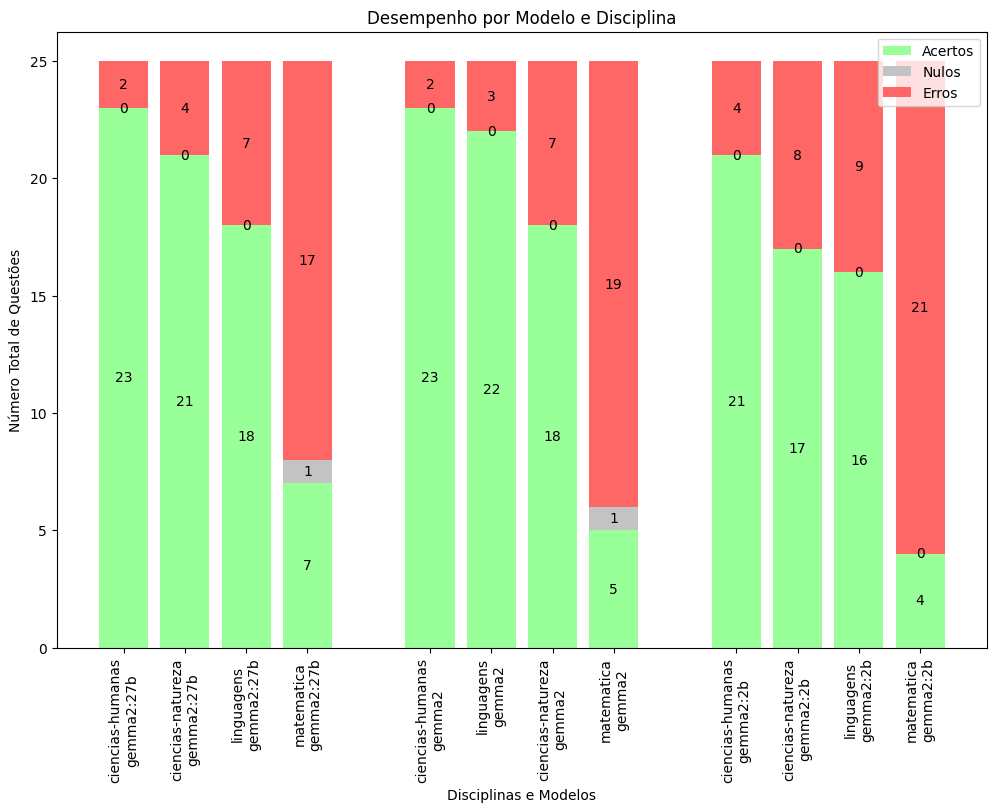

In [5]:
gemma_models = ["gemma2:2b", "gemma2", "gemma2:27b"]

test_result = test_models(
    primary_models=gemma_models,
    questions=example_text_questions
)

gemma_table = lib.utils.test_table(
    questions=example_text_questions,
    models=gemma_models
)

clear_output(wait=True)
display(lib.utils.format_test_table(gemma_table))
plots.model_performance(gemma_table, "Desempenho de Modelos com Quantidade de Parâmetros Diferentes")
plots.time_metrics(gemma_table)
plots.time_metrics_total(gemma_table)
plots.correlation(gemma_table)
plots.correlation(gemma_table, "Size")
plots.discipline_performance(gemma_models, example_text_questions, True, False)
None

['gemma2:2b', 'gemma2', 'gemma2:27b']
A função foi alterada!
{'2009161-gemma2': {'question': '2009161', 'model': 'gemma2', 'response': '(C) \n', 'answer': 'C', 'correct': False, 'time': 0.4675673, 'response_length': 5, 'discipline': 'matematica', 'timeout': None}, '2009175-gemma2': {'question': '2009175', 'model': 'gemma2', 'response': "(C) \n\n\nHere's how to solve the problem:\n\n**Let's use the given information and formulas:**\n\n* **ICadÚnico = (TC + TA) / 2**\n* **TC = NV / NF**\n* **TA = NA / NV**\n\n* We know IcadÚnico = 0.6 when NF is its original value.\n* Doubling NF makes the IcadÚnico fall to 0.5.  We can set up equations based on these scenarios.\n\n**Setting up the equations:**\n\n1. **Initial situation (Original NF):**\n   0.6 = (NV / NF + NA / NV) / 2\n\n2. **New situation (Doubled NF):**\n   0.5 = (NV / (2 * NF) + NA / NV) / 2\n\n* We also know that **NA + NV = 3600**.\n\n**Solving for NF:**\n\nThe problem involves solving a system of equations. This can be complex, b

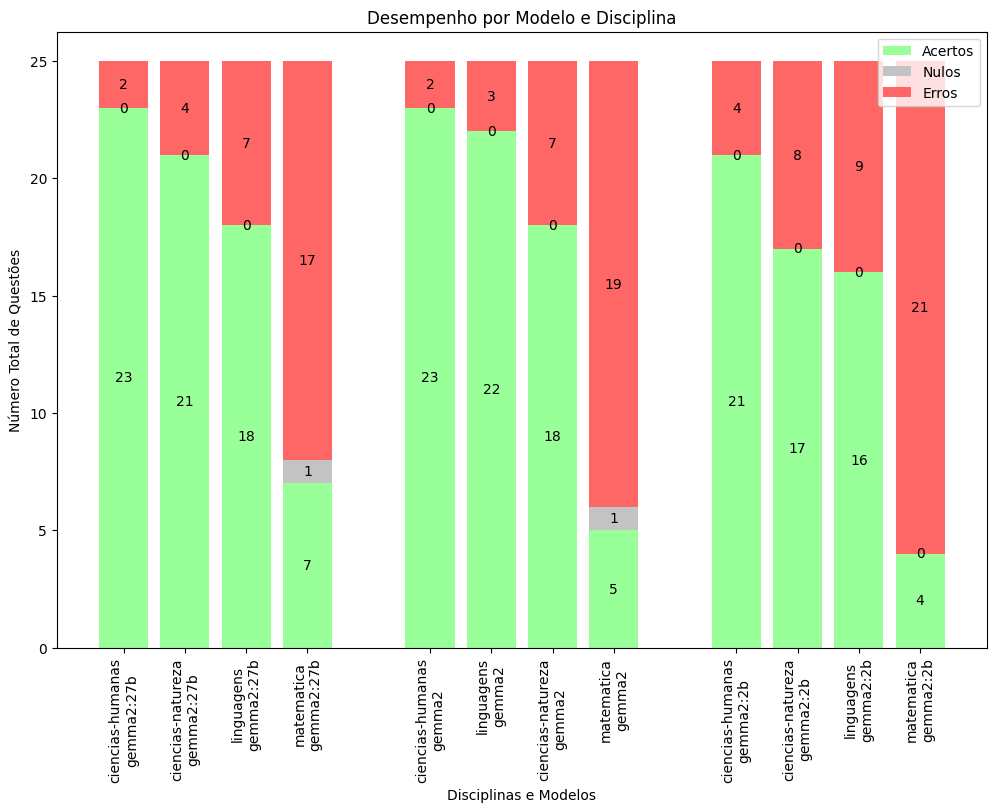

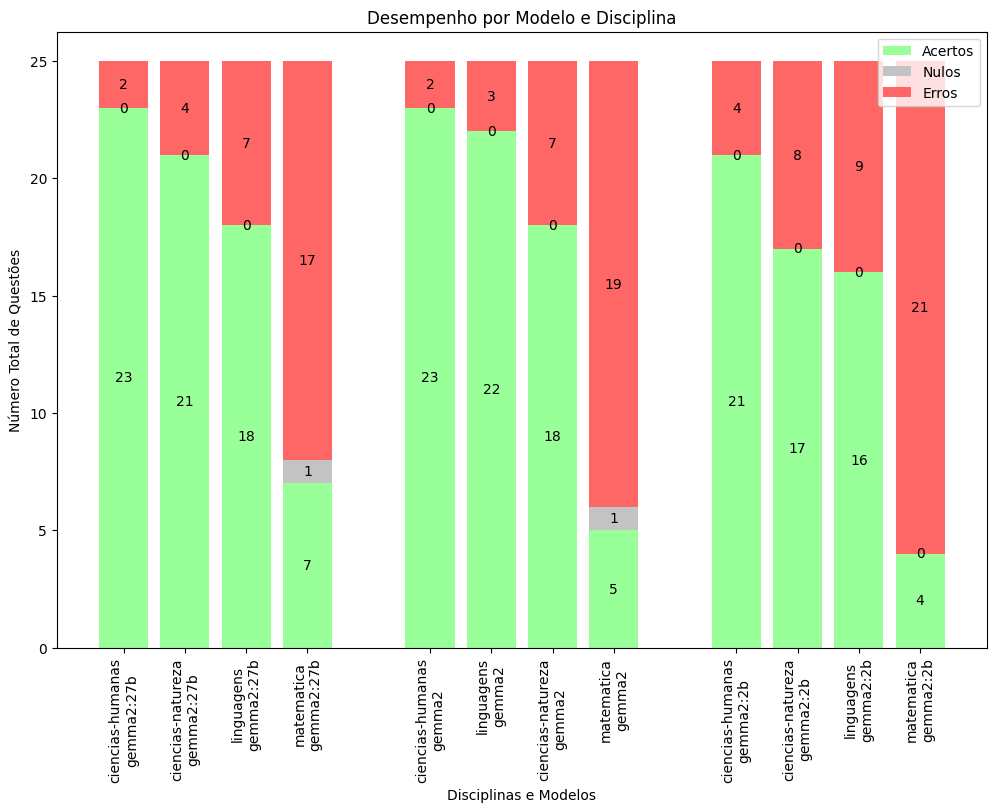

In [6]:
plots.discipline_performance(gemma_models, example_text_questions, True, False)

#### 2.1.3 - Análise Comparativa dos Modelos  

Com base nos dados apresentados, observamos que há uma **diferença significativa** de desempenho entre os modelos mais robustos e os modelos mais leves. No entanto, ao compararmos um modelo **intermediário** com um modelo mais robusto, essa diferença torna-se **pouco expressiva**, sugerindo que modelos intermediários podem oferecer um desempenho equivalente na maioria dos cenários. No caso do **Gemma2**, identificamos uma variação entre os acertos por disciplina, com **diferenças mais notáveis entre os modelos**, o que indica que alguns domínios podem ser mais sensíveis à quantidade de parâmetros do modelo.  

##### **Impacto Temporal e Considerações Computacionais**  

Em termos de **tempo de inferência**, o modelo mais robusto apresentou **tempos de execução mais elevados** em todos os testes. Esse comportamento pode ser explicado por dois fatores principais:  

1. **Consumo de memória** – Modelos maiores tendem a exigir mais memória, sendo preferencialmente executados em **memória de vídeo (VRAM)** para maior eficiência. No entanto, se o modelo ultrapassar a capacidade da GPU disponível, ele será carregado na **memória RAM**, que possui uma **frequência menor**, impactando diretamente no tempo de inferência.  
2. **Número de combinações avaliadas** – Modelos com maior número de parâmetros possuem **mais possibilidades de ajuste para cada predição**, o que pode levar a um aumento no tempo de resposta.  

Esses fatores reforçam a necessidade de um equilíbrio entre **qualidade da resposta e viabilidade computacional**, especialmente em aplicações que demandam tempo de resposta reduzido e menor consumo de recursos.  

In [ ]:
from lib.utils import get_predict_data
import pandas as pd

predict_data = get_predict_data(["gemma2", "gemma2:27b", "qwen2.5:14b", "qwen2.5:7b",], example_text_questions)

questoes = set(int(p["question"]) for p in predict_data.values())

predicts_list = []

for quest in questoes:
    predicts_list.append({
        "question-model" : f"{quest}-gemma",
        "medium" : 1 if predict_data[f"{quest}-gemma2"]["correct"] else 0,
        "large" : 1 if predict_data[f"{quest}-gemma2:27b"]["correct"] else 0
    })
    
    predicts_list.append({
        "question-model" : f"{quest}-qwen2.5",
        "medium" : 1 if predict_data[f"{quest}-qwen2.5:7b"]["correct"] else 0,
        "large" : 1 if predict_data[f"{quest}-qwen2.5:14b"]["correct"] else 0
    })

predicts_df = pd.DataFrame(predicts_list)

A função foi alterada!


In [21]:
from scipy.stats import ttest_rel

t_stat, p_value = ttest_rel(predicts_df["medium"], predicts_df["large"])

print(f"Estatística t: {t_stat:.4f}, Valor-p: {p_value:.4f}")

# Definir nível de significância
alpha = 0.05

if p_value > alpha:
    print("Aceitamos H₀: Os modelos são estatisticamente equivalentes em acurácia.")
else:
    print("Rejeitamos H₀: Existe uma diferença significativa no desempenho dos modelos.")

Estatística t: -0.1597, Valor-p: 0.8732
Aceitamos H₀: Os modelos são estatisticamente equivalentes em acurácia.


In [22]:
from statsmodels.stats.weightstats import ttost_paired

# Definir intervalo de equivalência
eq_low, eq_high = -0.02, 0.02  

# Aplicação do TOST para testar equivalência
tost_p_value = ttost_paired(predicts_df["medium"], predicts_df["large"], low=eq_low, upp=eq_high)[0]

print(f"Valor-p do TOST: {tost_p_value:.4f}")

if tost_p_value < alpha:
    print("Rejeitamos H₀: Os modelos são estatisticamente equivalentes.")
else:
    print("Aceitamos H₀: Não há evidências suficientes para afirmar equivalência.")


Valor-p do TOST: 0.3162
Aceitamos H₀: Não há evidências suficientes para afirmar equivalência.


##### **Formulação e Teste da Hipótese Nula**  

Para avaliar a equivalência entre modelos intermediários e robustos, formulamos a seguinte hipótese estatística:  

**Hipótese Nula ($H_0$):**  
$$
\mu_{\text{intermediário}} = \mu_{\text{robusto}}
$$
Ou seja, a **média de acertos do modelo intermediário** ($\mu_{\text{intermediário}}$) é estatisticamente equivalente à **média de acertos do modelo robusto** ($\mu_{\text{robusto}}$), indicando que ambos possuem desempenhos similares.  

**Hipótese Alternativa ($H_1$):**  
$$
\mu_{\text{intermediário}} \neq \mu_{\text{robusto}}
$$
Essa hipótese alternativa indicaria que existe uma **diferença estatisticamente significativa** entre os modelos, sugerindo que um deles apresenta um desempenho superior ao outro.  

##### **Resultados dos Testes Estatísticos**  

Para validar essa hipótese, aplicamos **dois testes estatísticos**:  

1. **Teste t de Student**, que avalia se há uma diferença significativa entre os modelos.  
2. **Teste de Equivalência (TOST)**, que verifica se a diferença de desempenho entre os modelos está dentro de um intervalo previamente definido como aceitável.  

Os resultados obtidos foram os seguintes:  

- **Teste t de Student ($\alpha = 0.05$)**:  
  - Estatística t: **-0.1597**  
  - Valor-p: **0.8732**  
  - **Conclusão**: Como $p > 0.05$, **aceitamos $H_0$**, indicando que **não há diferença estatisticamente significativa** entre os modelos intermediário e robusto.  

- **Teste de Equivalência (TOST) com intervalo de $[-0.02, 0.02]$**:  
  - Valor-p: **0.3162**  
  - **Conclusão**: Como $p > 0.05$, **não há evidências suficientes para afirmar equivalência** dentro do intervalo estabelecido.  

##### **Interpretação dos Resultados**  

Os resultados obtidos demonstram que **os modelos intermediário e robusto possuem desempenhos estatisticamente similares**, pois o teste t de Student **não encontrou diferença significativa** entre eles. No entanto, o teste de equivalência **não conseguiu confirmar que os modelos estão dentro do intervalo de tolerância de ±2%**, o que significa que **a equivalência estatística não pode ser garantida dentro desse critério específico**.  

Dessa forma, podemos concluir que **o aumento no número de parâmetros não implica necessariamente em uma melhoria significativa no desempenho**, mas também que **não podemos afirmar que um modelo intermediário é equivalente a um robusto dentro da margem de erro estipulada**.  

Na prática, a escolha entre um modelo intermediário ou robusto deve considerar não apenas a acurácia estatística, mas também **fatores como tempo de inferência, consumo de memória e viabilidade computacional**, uma vez que modelos intermediários podem oferecer benefícios significativos em eficiência sem comprometer substancialmente a qualidade das respostas.  


### 2.2 - Avaliação de Modelos de Reasoning  

Nesta seção, analisamos o desempenho dos **modelos de Reasoning**, que, devido à sua estrutura avançada de processamento e raciocínio, são esperados apresentar **melhor desempenho** em tarefas que exigem lógica e cálculos mais complexos. Para esse experimento, utilizamos os seguintes modelos: **Deepscaler**, **Deepseek-r1**, **Mistral-nemo**, **Openthinker** e **Smallthinker** .

##### **Tempo de Execução e Uso de Tokens**  

Observamos uma **diferença significativa no tempo de inferência** desses modelos em comparação com os testados anteriormente. Alguns deles apresentaram a tag `<think>`, que representa uma etapa explícita de raciocínio antes da resposta final. Essa estrutura resultou em **respostas mais longas**, com um maior número de **tokens**, o que impactou diretamente no tempo de processamento.  

Um caso extremo foi o **Openthinker**, que levou **mais de 1h24min** para processar **100 questões**, resultando em uma média de aproximadamente **50 segundos por questão**. Em contraste, o modelo **Gemma2:27b**, que anteriormente apresentou o maior tempo de execução entre os modelos testados, levou **cerca de 12 minutos** para concluir o mesmo teste.  

Vale ressaltar que, diferentemente do **Gemma2:27b**, cujo tempo elevado se deve ao alto consumo de **VRAM**, os modelos de reasoning são **mais leves em tamanho**, sugerindo que o tempo prolongado pode estar mais relacionado ao **processamento adicional de raciocínio**. Essa tendência foi observada em **todos os modelos**, exceto pelo **Mistral-nemo**, que conseguiu um tempo de inferência reduzido. 

Um outro fator importante foi o excesso de **timeout**, com os demais modelos não tivemos problemas, mas o **smallthinker** apresentou uma incostância muito grande, travando a execução, tendo que ser implementado um timeout para impedir que ele interrompesse os teste.

##### **Acurácia e Desempenho por Disciplina**  

Em relação às **métricas de acurácia**, os resultados foram variados:  

- Apenas o **Deepscaler** apresentou um desempenho **inferior** aos modelos convencionais testados anteriormente.  
- Os demais modelos tiveram valores **próximos** aos obtidos pelos modelos **não-reasoning**.  
- Em **matemática**, esperava-se que os modelos reasoning apresentassem **um desempenho superior**, devido à sua **capacidade aprimorada de cálculos**. No entanto, apenas o **Deepseek-r1** obteve **mais de 50% de acertos** nessa disciplina, enquanto nas demais áreas seu desempenho foi inferior, especialmente em **ciências da natureza**.  

##### **Respostas Nulas e Impacto no Não-Determinismo**  

Um fenômeno observado nesses modelos foi a **alta taxa de respostas nulas**, especialmente em **matemática**. Respostas nulas ocorreram quando o modelo **não seguiu corretamente a instrução de resposta**, por exemplo:  

- Em vez de fornecer a **alternativa correta**, o modelo apresentava o **resultado do cálculo**.  
- Algumas respostas continham explicações extensas, mas sem indicar diretamente a alternativa correta.  

Esse comportamento indica que a **camada adicional de raciocínio pode impactar o determinismo do modelo**, tornando suas respostas menos previsíveis e mais propensas a **desvios das instruções originais**.  

##### **Considerações Finais**  

Os modelos de reasoning apresentaram **vantagens e desvantagens** claras. Enquanto alguns conseguiram **bons desempenhos em acurácia**, houve um **custo expressivo em tempo de inferência**. Além disso, a **tendência a respostas mais elaboradas e menos diretas** pode ser um desafio em aplicações que exigem **alta confiabilidade e aderência estrita às instruções**.  


,Model,Size,Finish,OK,Null,Err,Tout,Acc,Ttot,TTout,Tle,Tavg,Tmax,Tmin
0,deepseek-r1,7.0,100 (100.0%),65,0,35,0,0.650,32:32,32:32,0.00,19.53,01:52,4.96
1,mistral-nemo,7.1,100 (100.0%),65,0,35,0,0.650,04:34,04:34,0.00,2.75,14.25,0.22
2,openthinker,4.7,100 (100.0%),60,0,40,0,0.600,01:24:44,01:24:44,0.00,50.85,09:02,9.70
3,smallthinker,3.6,100 (100.0%),53,11,25,11,0.530,18:20,40:20,0.00,11.00,27.32,4.87
4,deepscaler,3.6,100 (100.0%),29,0,71,0,0.290,43:28,43:28,0.00,26.08,05:24,3.82
5,TOTAL,26.0,500 (100.0%),272,11,206,11,0.544,03:03:40,22:00,ND,22.04,09:02,0.22


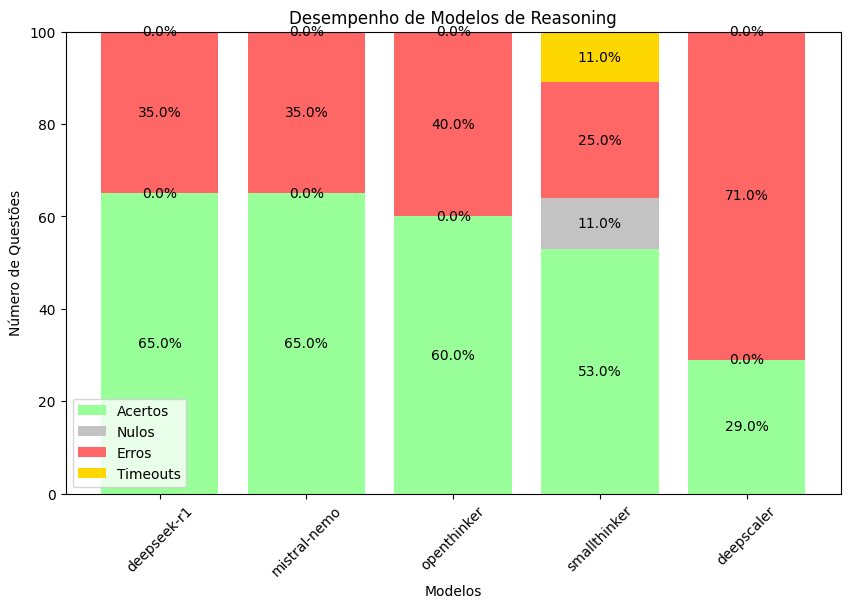

In [8]:
reason_models = ["deepscaler", "deepseek-r1", "mistral-nemo", "openthinker", "smallthinker"]

test_result = test_models(
    primary_models=reason_models,
    questions=example_text_questions,
    timeout = 100
)

reason_table = lib.utils.test_table(
    questions=example_text_questions,
    models=reason_models
    
)

clear_output(wait=True)
display(lib.utils.format_test_table(reason_table))
plots.model_performance(reason_table, "Desempenho de Modelos de Reasoning")
None

Analisando a acurácia do modelos, notamos que o desempenho se mostrou bastante similar aos modelos anteriores, demonstrando que talvez uma algoritmo de reasoning não tenha sido tão eficiente comparado com outros modelos. Outro ponto interessante é que o openthinker teve um desempenho próximo dos outros melhores modelos.

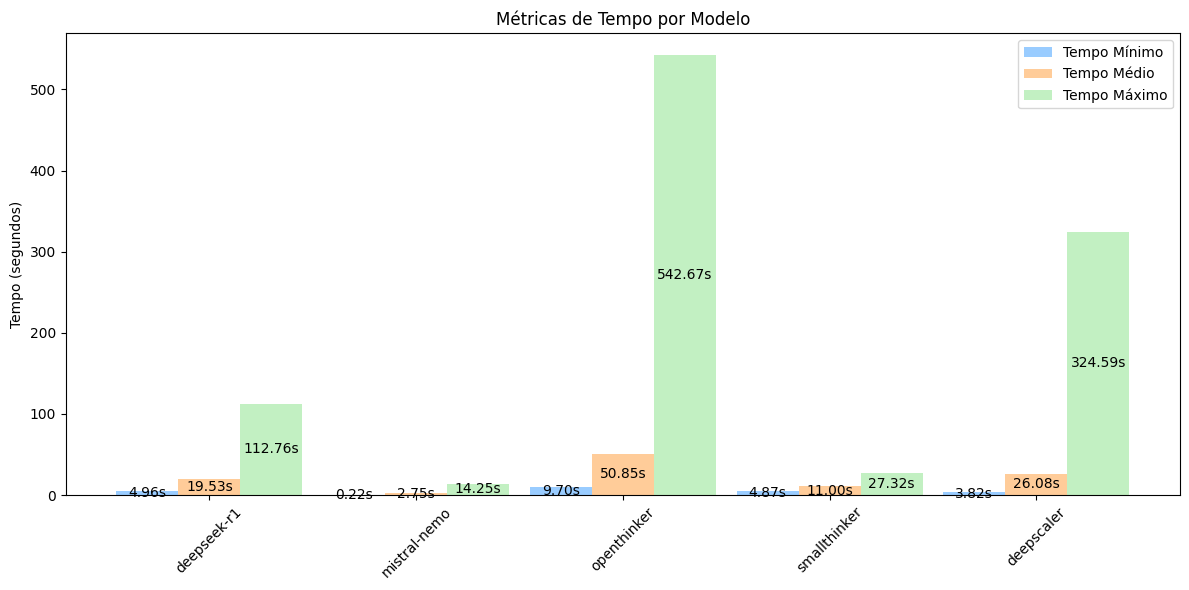

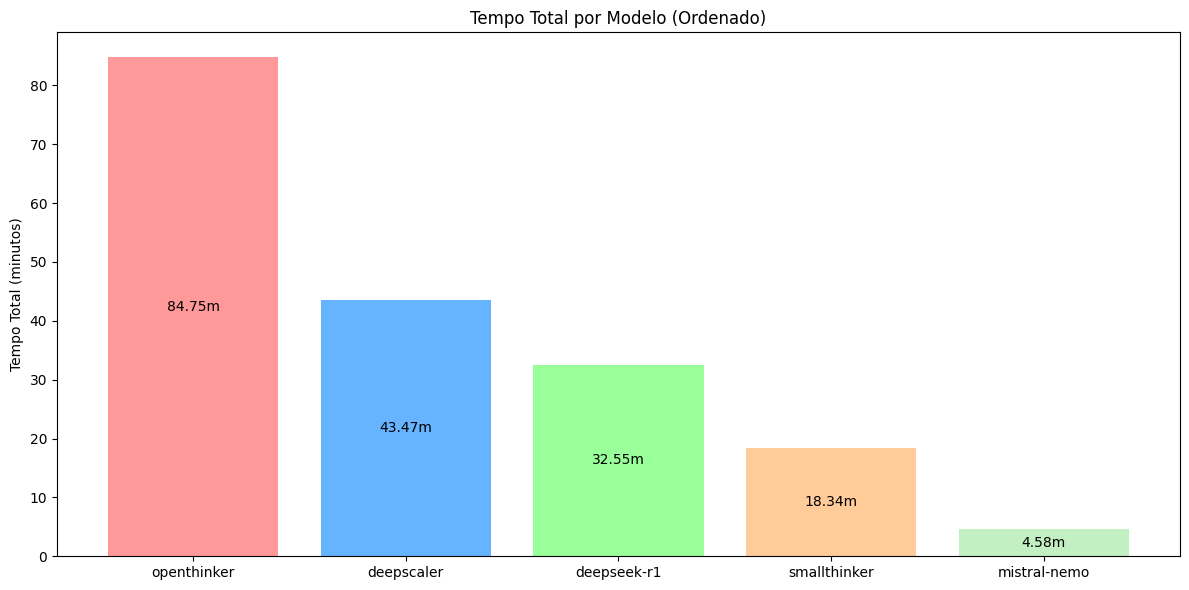

In [9]:
plots.time_metrics(reason_table)
plots.time_metrics_total(reason_table)
None

Porém ao analisarmos o tempo dos modelos, o **ministral-nemo** possuiu um tempo bastante similar aos dois modelos anteriores, porém, nos demais, principamente o openthinker apresentaram tempos muito superiores, chegando a quase 18.5x do modelo com menor tempo, ou seja, tivemos uma acurácia nos melhores casos muito próxima dos modelos anteriores que possuem um tempo significamente menor. É importante, pontuar que os modelos com exceção ao ministral-nemo, tiveram um tempo máximo muito alto, chegado a mais de 500 segundos em um exemplo. 

### 2.3 - Modelos focados em Matemática

Selecionamos alguns modelos focados em matemática como ..., incluindo a variação de modelo de dois desses algoritmos.

,Model,Size,Finish,OK,Null,Err,Tout,Acc,Ttot,TTout,Tle,Tavg,Tmax,Tmin
0,mathstral,4.1,100 (100.0%),56,0,44,0,0.560000,10:38,10:38,0.00,6.39,23.44,0.25
1,qwen2-math:7b,4.4,100 (100.0%),37,0,63,0,0.370000,40.43,40.43,0.00,0.40,4.43,0.16
2,qwen2-math:1.5b,0.9,100 (100.0%),26,0,74,0,0.260000,04:35,04:35,0.00,2.76,6.40,0.21
3,TOTAL,9.4,300 (100.0%),119,0,181,0,0.396667,15:54,0.00,ND,3.18,23.44,0.16


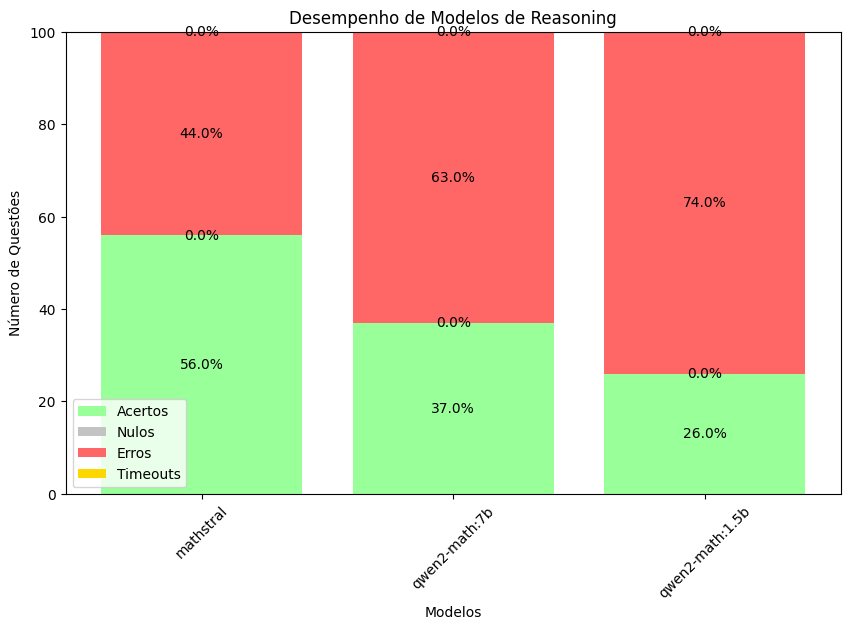

In [10]:
math_models = ["qwen2-math:1.5b", "qwen2-math:7b", "mathstral"]

math_table = lib.utils.test_table(
    questions=example_text_questions,
    models=math_models
)

display(lib.utils.format_test_table(math_table))
plots.model_performance(math_table, "Desempenho de Modelos de Reasoning")
None

A acurácia desses modelos foram inferiores aos anteriores, o que sugere que esses algoritmos voltados para matemática não conseguiram se sair bem nas demais disciplinas. Porém um dado curioso é da baixa diferença entre as variações do qwen2-math, porém o modelos mais curto teve um tempo médio muito superior, porém o modelo mathstral, que tem um tamanho próximo do qwen2-math:7b, demorou quase 10min para concluir os testes.

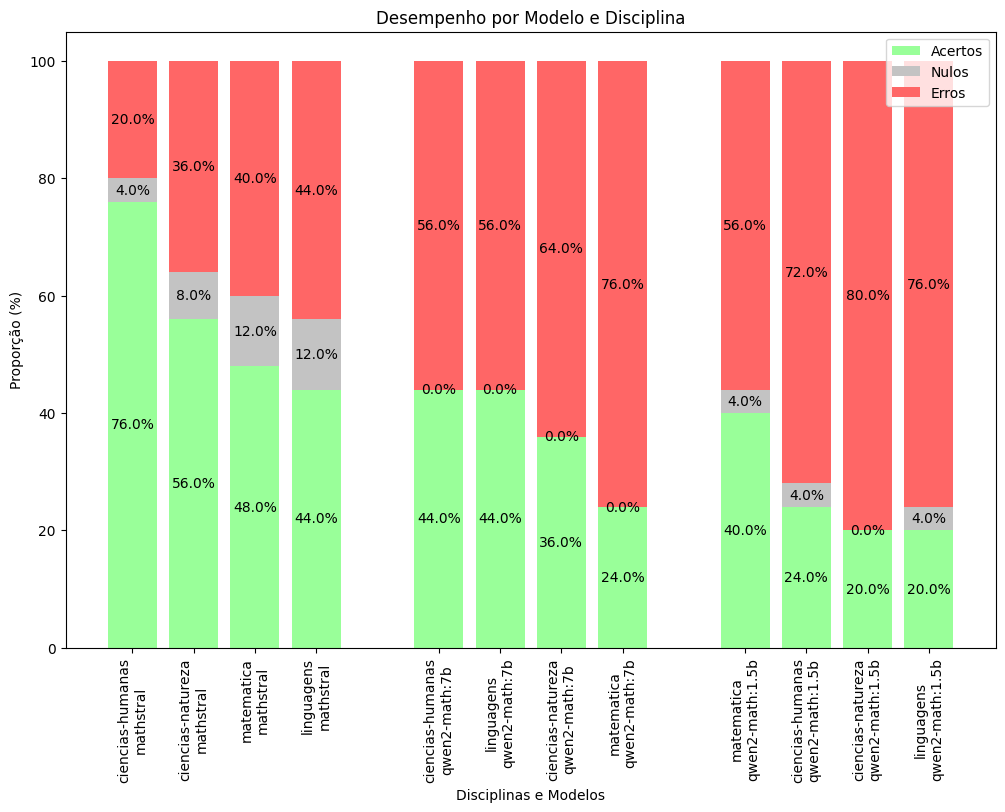

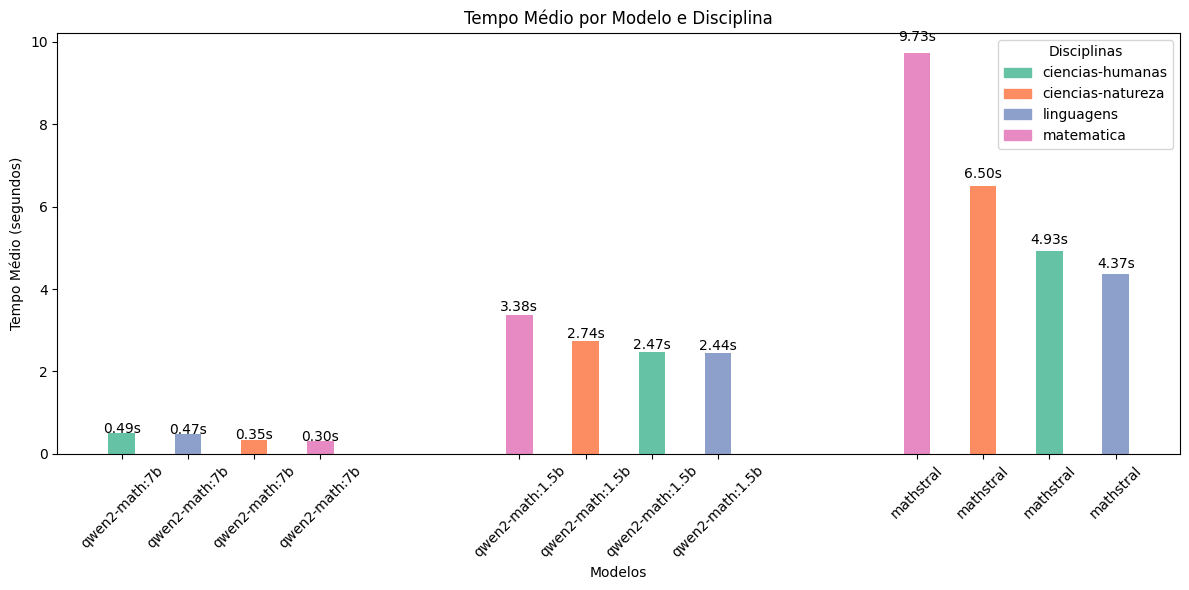

In [11]:
plots.discipline_performance(math_models, example_text_questions,True, True)
plots.discipline_time_performance(math_models, example_text_questions, True)
None

Porém ao anasisarmos o desempennho de cada disciplina por modelo, notamos que não houve uma melhora significativa em questões de matemática como esperamos, o que possuiu um melhor desempenho foi, o surpreendente **qwen2-math:1.5b**, mesmo com uma quantidade muito inferior de parâmetros obteve o melhor resultado, mesmo gastando um pouco mais de tempo que os demais.

### 2.4 - Demais Modelos
Por fim treinamos o restante dos modelos de texto, e um modelo com suporte a viasão, para tentar compreender se algum modelo que possui um foco em vários modias consegue ter um desempenho próximo a um modelo dedicado

,Model,Size,Finish,OK,Null,Err,Tout,Acc,Ttot,TTout,Tle,Tavg,Tmax,Tmin
0,phi4,9.1,100 (100.0%),86,0,14,0,0.86,12:34,12:34,0.00,7.55,32.99,1.70
1,mistral-small,14.0,100 (100.0%),78,0,22,0,0.78,44:21,44:21,0.00,26.61,04:11,1.02
2,gemma2,5.4,100 (100.0%),68,0,32,0,0.68,58.63,58.63,0.00,0.59,8.83,0.28
3,mistral,4.1,100 (100.0%),51,0,49,0,0.51,01:57,01:57,0.00,1.18,20.85,0.22
4,llava,4.7,100 (100.0%),40,0,60,0,0.40,01:16,01:16,0.00,0.76,10.90,0.18
5,llama3.2,2.0,100 (100.0%),25,0,75,0,0.25,30.14,30.14,0.00,0.30,7.85,0.09
6,phi3.5,2.2,100 (100.0%),16,0,84,0,0.16,13:23,13:23,0.00,8.04,02:07,0.29
7,TOTAL,41.5,700 (100.0%),364,0,336,0,0.52,01:15:02,0.00,ND,6.43,04:11,0.09


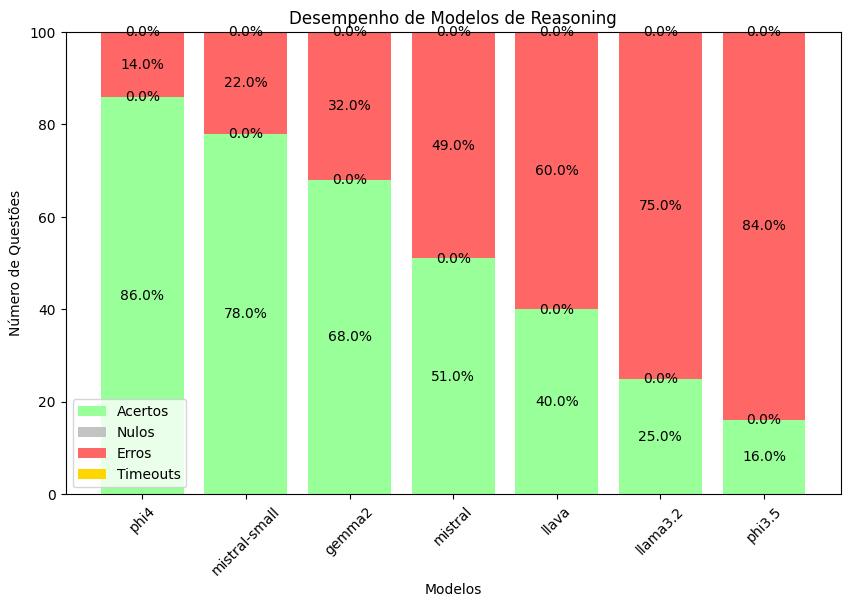

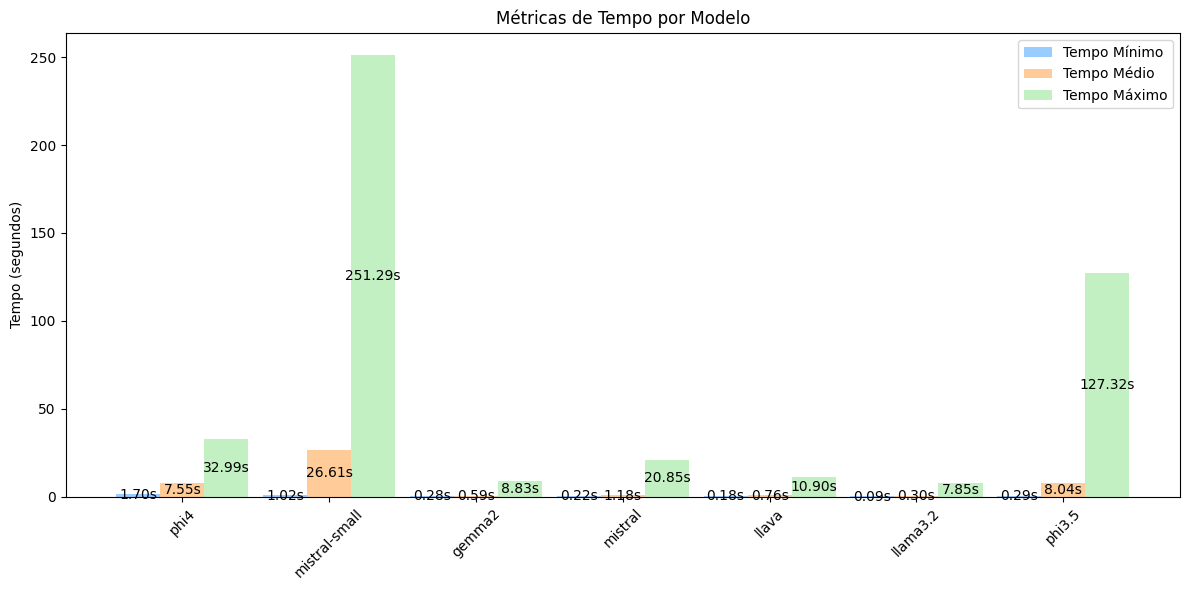

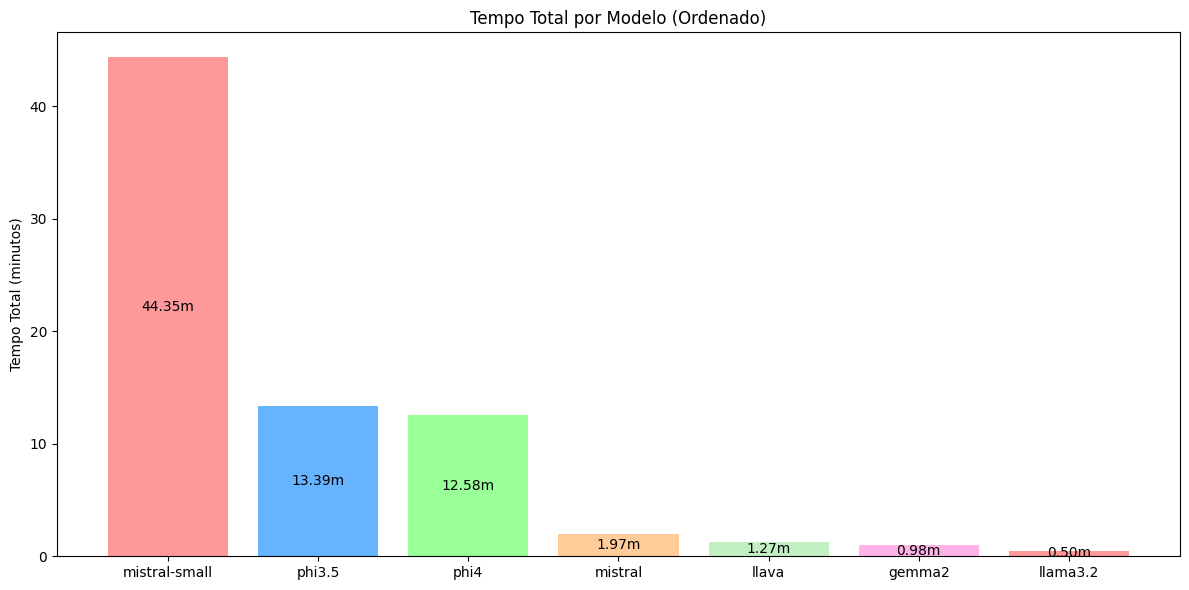

In [12]:
text_models = ["phi4", "phi3.5", "gemma2", "llava", "llama3.2", "mistral", "mistral-small"]

text_table = lib.utils.test_table(
    questions=example_text_questions,
    models=text_models
)

display(lib.utils.format_test_table(text_table))
plots.model_performance(text_table, "Desempenho de Modelos de Reasoning")
plots.time_metrics(text_table)
plots.time_metrics_total(text_table)
None

Nesse resultado tivemos uma ótima surpresa, os modelos **phi4** e **mistral-small** conseguiram uma acurácia acima de 70%, e o **gemma2** não ficou muito pra trás, chegando em 68%, porém o tempo do mistral-small foi muito superior aos demais, levando quase 44min para concluir o teste. Os modelos da Microsoft também tiveram um tempo considerável.

Um desempenho incomum aconteceu com o modelo phi3.5, nas primeiras questões ele conseguiu ter uma boa acurácia, pore´m com o passar do tempo ele começou a responder coisas totalmente distintas do que deveriam ser respondidas, o que impactou significamente no número de questões nulas.

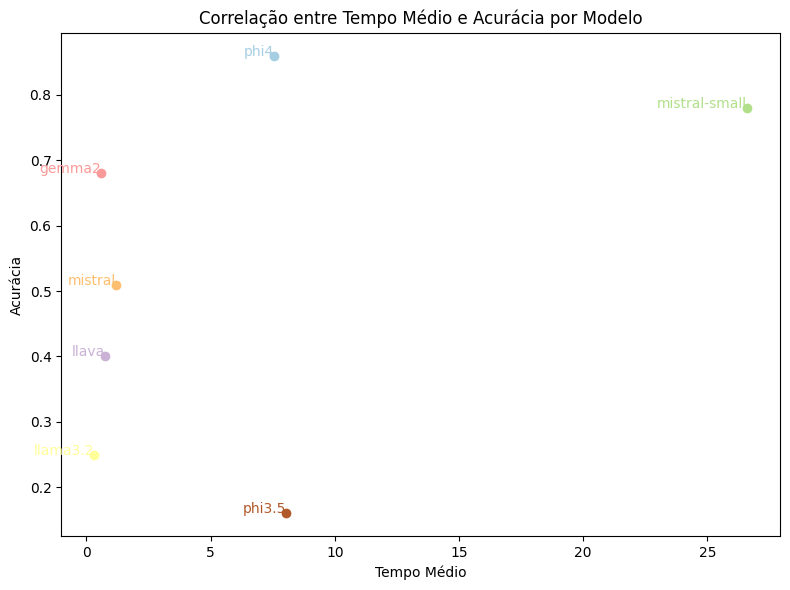

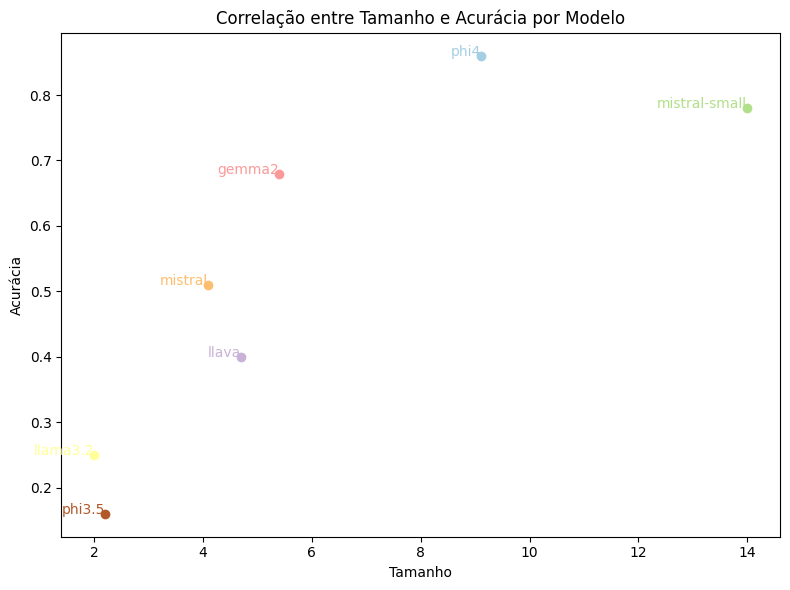

In [13]:
plots.correlation(text_table, "Tavg", "Acc")
plots.correlation(text_table, "Size", "Acc")
None

E utilizando a matriz de correlação, podemos concluir que os dois modelos que mais se destacaram nesse teste foram os de **phi4** e **gemma2**, pois tiveram uma ótima performance sem gastar tanto tempo, e não precisam de uma memória tão grande como o caso do modelo minstral-small, no qual o tempo pode ter sido impactado com a liitação do hardware, pois foi utilizada uma placa de 12GB e VRAM, e o modelo tem um tamanho de 14GB, logo, o modelo não pode ter sido carregado totalmente na VRAM, tendo que ser armazenado também na memória RAM, gastandomais tempo para o carregamento do modelo, impactando assim a velocidade do modelo.

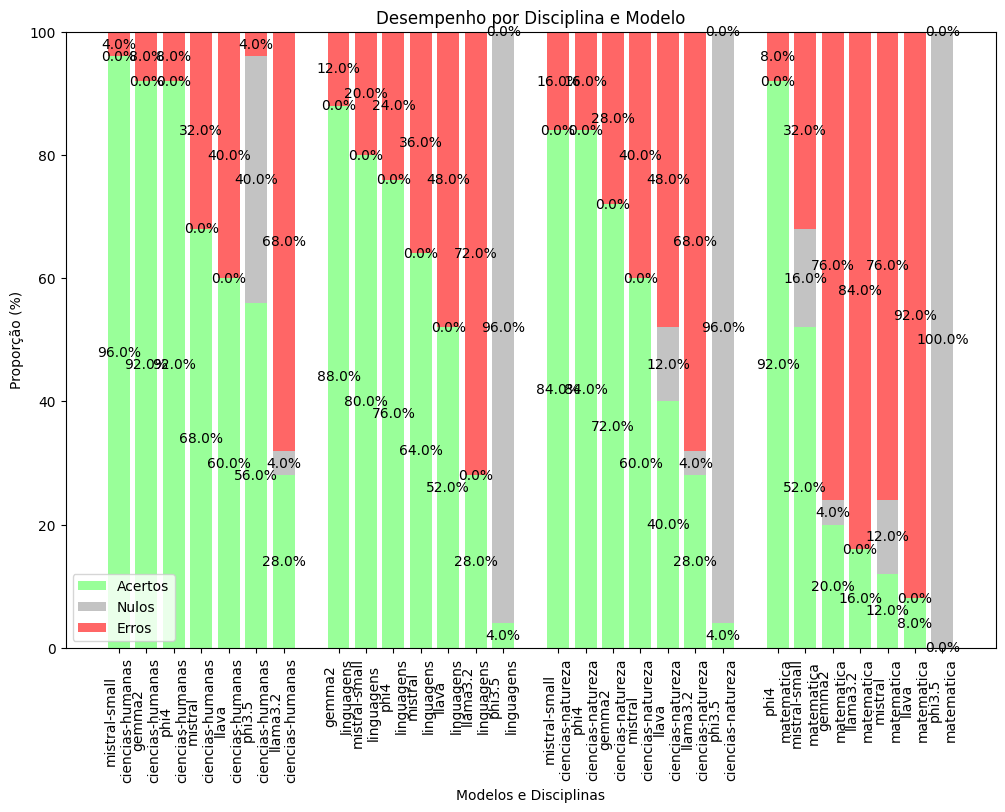

In [14]:
plots.discipline_performance(text_models, example_text_questions, normalize=True)
None

E no desempenho por disciplina, curiosamente o modelos de **phi4** e **mistral-small** conseguiram um desempenho superior em matemática do que os modelos focados em matemática, com o **phi4** atingindo impressionantes 92% de precisão, e um desempenho constante em todas as outras disciplinas, o que sugere sua alta taxa de desempenho comparado com os demais.

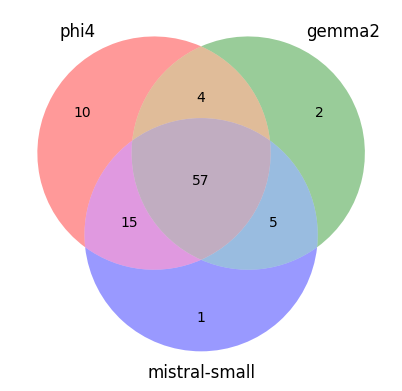

In [15]:
plots.venn(example_text_questions, 'phi4', 'gemma2', 'mistral-small')

E ao observarmos o Diagrama de Venn, notamos que das 14 questões que o phi4 não conseguiu acertar, os outros 2 melhores modelos conseguiram acertar 8.

### 2.5 Resultado por Disciplinas

In [16]:
all_text_models = qwen_models + math_models + reason_models + text_models
text_table = lib.utils.tabela_geral(example_text_questions, all_text_models)
table_disciplinas = lib.utils.analisar_tabela(text_table, 'discipline')
table_disciplinas

,discipline,Total,OK,Null,Err,Tout,Ttot,TTout,Tle,Tavg,Tmax,Tmin
0,ciencias-humanas,450.0,293.0,13.0,144.0,0.0,2216.421111,0.0,2216.421111,4.925380,127.324694,0.082505
1,ciencias-natureza,450.0,246.0,39.0,165.0,0.0,3363.931982,0.0,3363.931982,7.475404,173.496423,0.080599
2,linguagens,450.0,245.0,35.0,170.0,4.0,2286.582571,0.0,2286.582571,5.081295,77.246623,0.000000
3,matematica,450.0,141.0,68.0,241.0,7.0,8732.506938,0.0,8732.506938,19.405571,542.666862,0.000000


Observando o desemprenho individual de cada disciplina em todos os modelosde texto, nota-se que Matemática é a principal dificuldade dos modelos, uma vez que o seu tempo de execução é superior aos demais somados, além de que a Acurácia de Todos os modelos chegou a 31.33%, enquanto os outros modelos conseguiram uma acurácia entre 54.44% a 65.11%

#### 2.5.1 Matemática

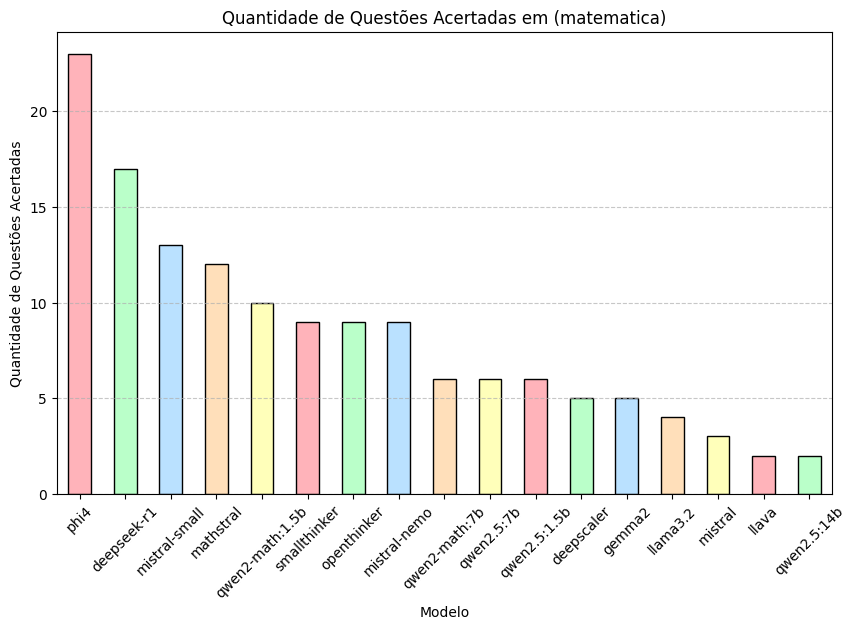

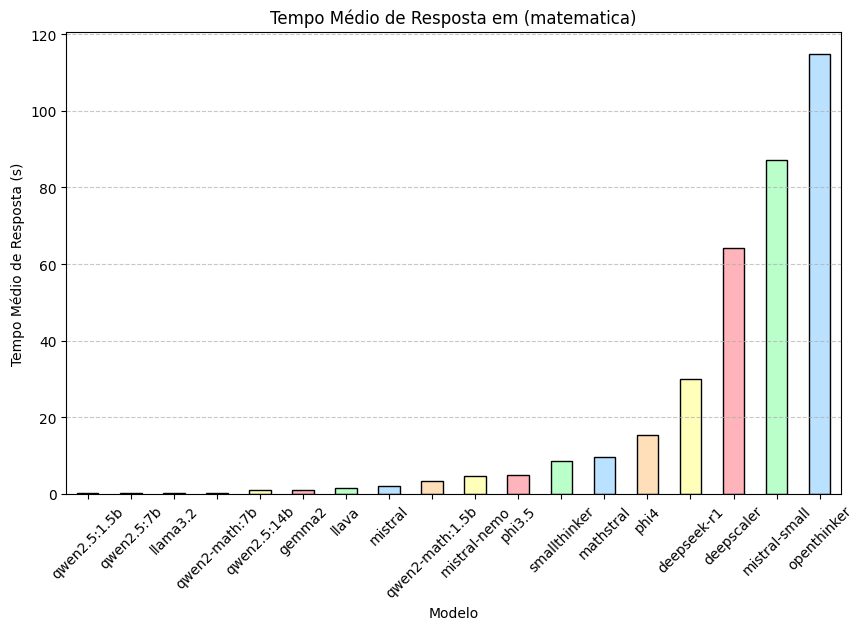

In [17]:
plots.discipline_models(text_table, 'matematica', 'acc')
plots.discipline_models(text_table, 'matematica', 'time')

Nota-se que a escalada de tempo é muito maior do que a de resultados, e geralmento os modelos com maior tempo de execução foram os que sairam melotr, porém, nem tanto tempo significa acurácia, pois o modelo com maior acurácia teve um tempo bem menor do que o tempo do modelo mais demorado, que teve um desempenho médio. É importante notar, também, que apenas 4 dos modelos testados conseguiram acertar mais da metade das questões.

#### 2.5.2 Linguagens

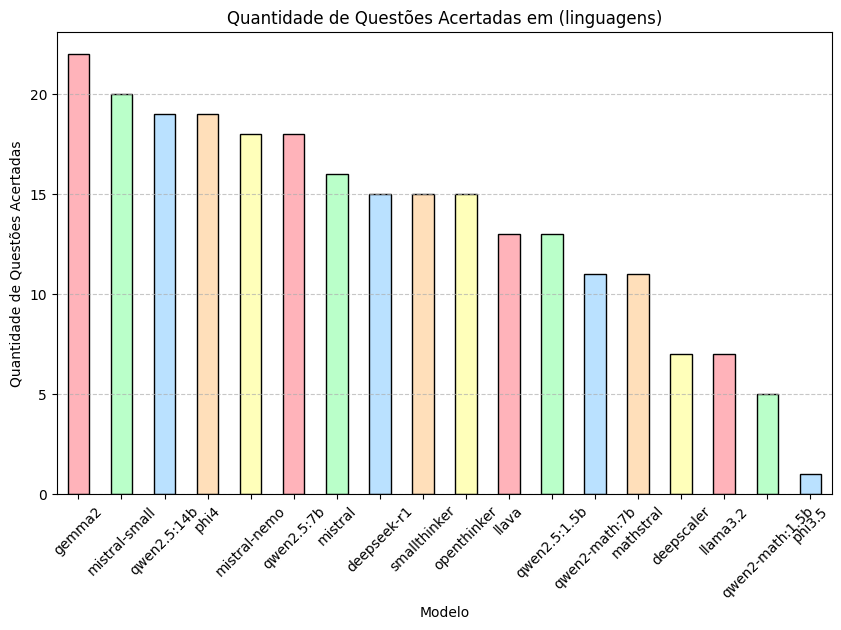

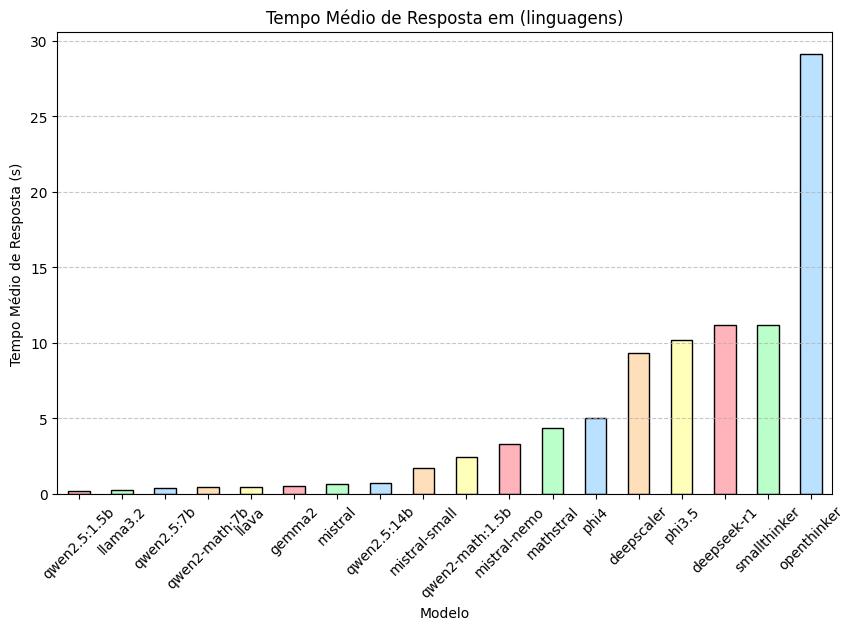

In [18]:
plots.discipline_models(text_table, 'linguagens', 'acc')
plots.discipline_models(text_table, 'linguagens', 'time')

Nesse cenário nota-se métricas muito melhores, com a maioria dos modelos conseguindo acertar 15 ou mais questões, e com um tempo de resposta muito inferior ao de matemática, com apenas 5 modelos tendo tempo médio superior a 5 segundos.

#### 2.5.3 Ciências Humanas

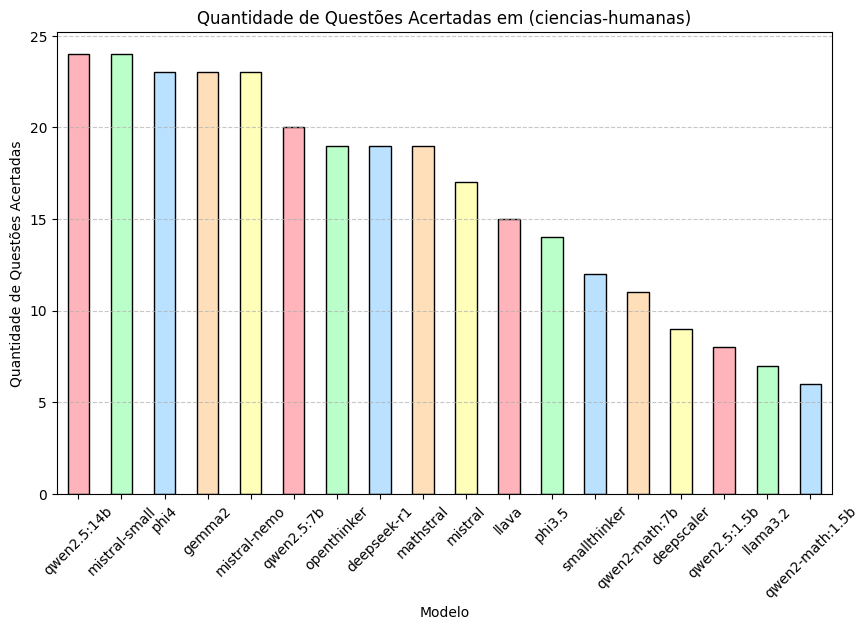

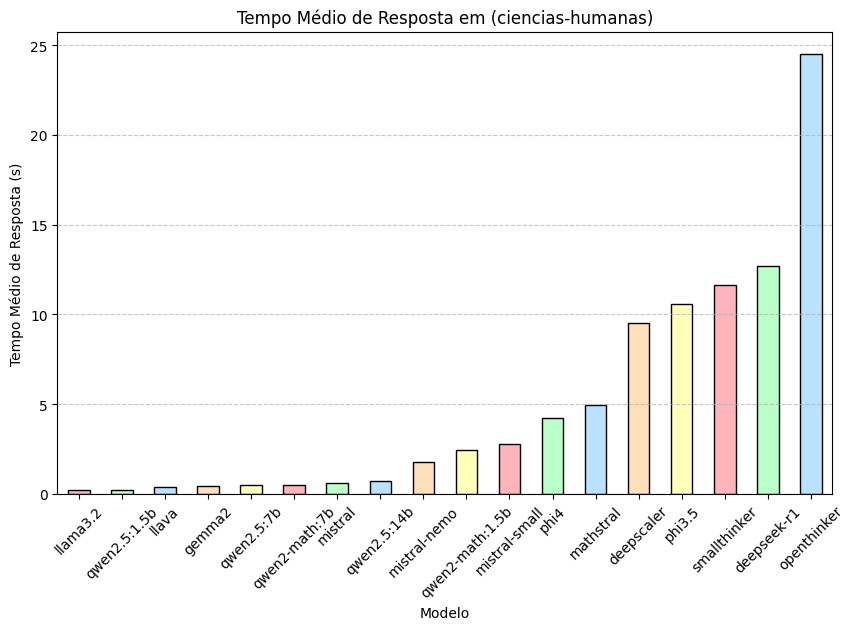

In [19]:
plots.discipline_models(text_table, 'ciencias-humanas', 'acc')
plots.discipline_models(text_table, 'ciencias-humanas', 'time')

Aqui temos um cenário muito similar ao de linguagens, porém com uma índice de acerto um pouco maior. Esse fato se deve muito provavelmente a que algumas questões de ciências humanas são mais objetivas do que interpretativa, como por exemplo, para identificar o pensamento de algum filósofo.

#### 2.5.4 Ciências da Natureza

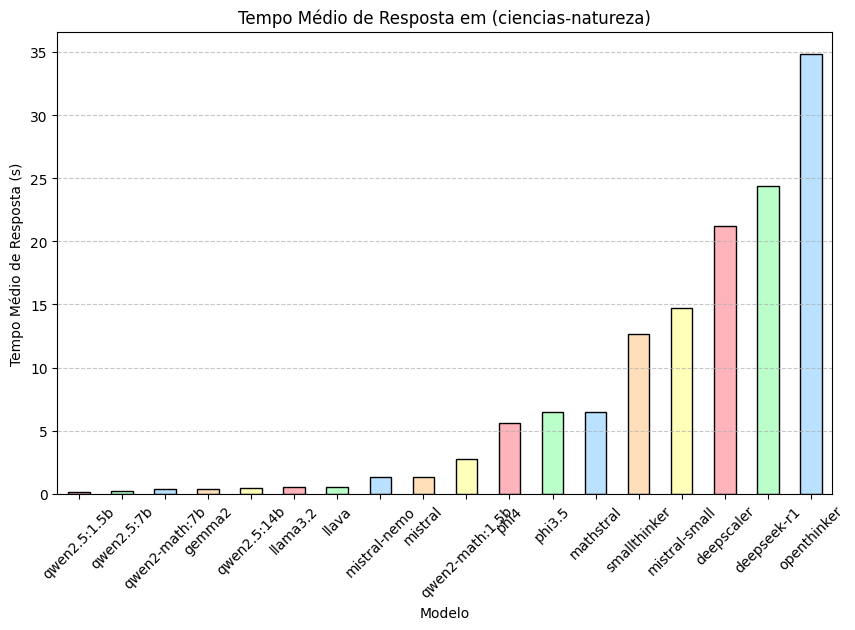

In [20]:
plots.discipline_models(text_table, 'ciencias-natureza', 'acc')
plots.discipline_models(text_table, 'ciencias-natureza', 'time')

Por fim, nas disciplinas de ciências na natureza, notamos o mesmo desemprenho de ciências humanas, porém com um fator de escala exponencial inferior (entre os modelos), e com um tempo médio um pouco superior.

### 2.6 Resultados por Questões

In [21]:
table_question = lib.utils.analisar_tabela(text_table, 'question')
table_question = table_question[table_question['Total'] > 10]

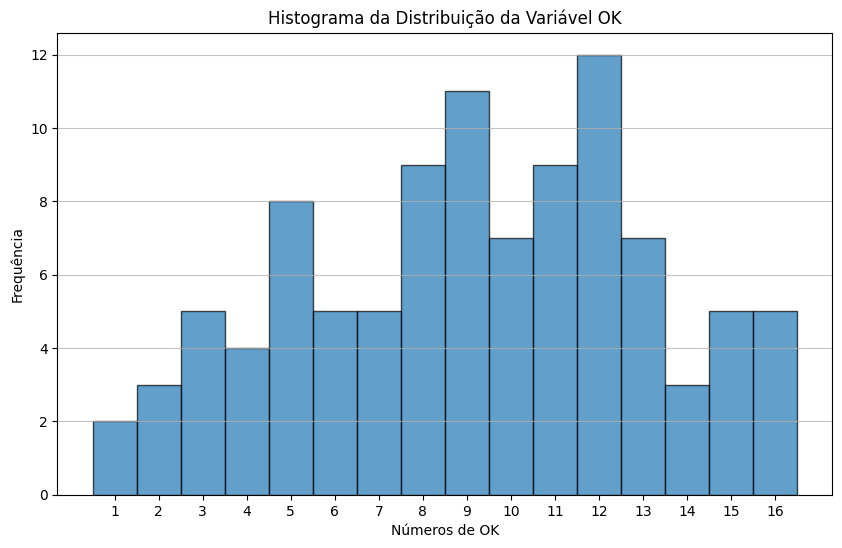

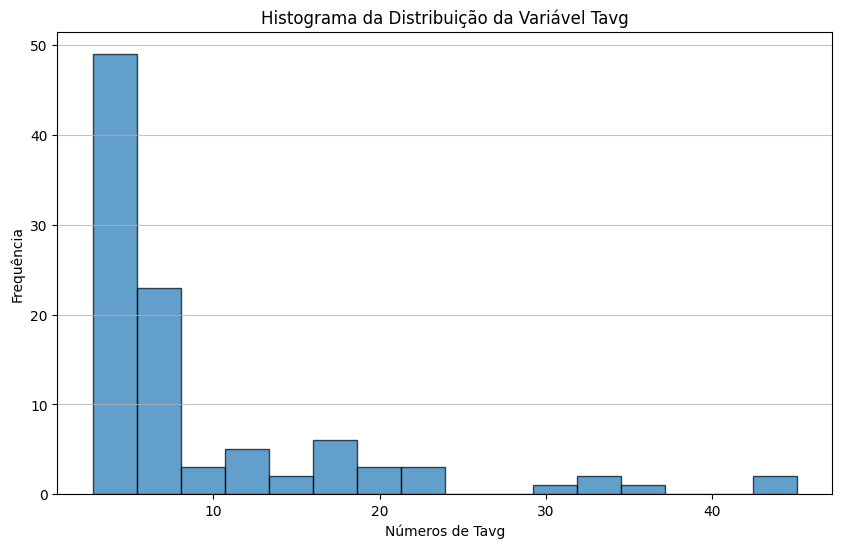

,OK,Tavg
count,100.000000,100.000000
mean,9.160000,9.322356
std,3.915058,8.735102
min,1.000000,2.738627
25%,6.000000,4.309601
50%,9.000000,5.408893
75%,12.000000,10.669667
max,16.000000,45.102289


(np.int64(0), np.int64(5))

In [22]:
table_question = lib.utils.analisar_tabela(text_table, 'question')
table_question = table_question[table_question['Total'] > 10]
plots.histogram(table_question, 'OK', 100)
plots.histogram(table_question, 'Tavg', 30)


display(table_question[['OK', 'Tavg']].describe())

(table_question['OK'] == 0.0).sum(), (table_question['OK'] == 16.0).sum()

Por fim, esta é a distribuição de questões corretas, todas as questões tevieram ao menos algum modelo que conseguiram acertar, e a questão mais acertada teve 5 acertos, a média de acerto é de 8.73.

Observando a perpectiva temporal, a distribuição de tempo médio por questão se concentra bastante no primeiro terço da distribuição, tendo 75% de toda a distribuição apenas em 11.3 segundos

#### 2.6.1 Questões mais difíceis

As duas questões que tiveram apenas 1 acerto foram uma de Linguagens e outra de Ciências da Natureza, respectivamente dos anos de 2013 e 2018.

In [23]:
(table_question[table_question['OK'] == 1.0])

,question,Total,OK,Null,Err,Tout,Ttot,TTout,Tle,Tavg,Tmax,Tmin
98,2013123,18.0,1.0,1.0,16.0,0.0,78.059693,0.0,78.059693,4.336650,17.146971,0.244754
99,2018134,18.0,1.0,2.0,15.0,0.0,96.888755,0.0,96.888755,5.382709,28.602754,0.095900


##### 2.6.1.1 Questão 2013123 - Linguagens

**Para Carr, internet atua no comércio da distração**

_Autor de “A Geração Superficial” analisa a influência da tecnologia na mente_

O jornalista americano Nicholas Carr acredita que a internet não estimula a inteligência de ninguém. O autor explica descobertas científicas sobre o funcionamento do cérebro humano e teoriza sobre a influência da internet em nossa forma de pensar.  
Para ele, a rede torna o raciocínio de quem navega mais raso, além de fragmentar a atenção de seus usuários.  
Mais: Carr afirma que há empresas obtendo lucro com a recente fragilidade de nossa atenção. “Quanto mais tempo passamos _on-line_ e quanto mais rápido passamos de uma informação para a outra, mais dinheiro as empresas de internet fazem”, avalia.  
“Essas empresas estão no comércio da distração e são _experts_ em nos manter cada vez mais famintos por informação fragmentada em partes pequenas. É claro que elas têm interesse em nos estimular e tirar vantagem da nossa compulsão por tecnologia.”

ROXO, E. **Folha de S. Paulo**, 18 fev. 2012 (adaptado).

(A) : Mantém os usuários cada vez menos preocupados com a qualidade da informação.

(B) : Torna o raciocínio de quem navega mais raso, além de fragmentar a atenção de seus usuários.

(C) : Desestimula a inteligência, de acordo com descobertas científicas sobre o cérebro.

(D) : Influencia nossa forma de pensar com a superficialidade dos meios eletrônicos.

(E) : Garante a empresas a obtenção de mais lucro com a recente fragilidade de nossa atenção.

| **Resposta:** (E)

#### 2.6.2 Questões mais Fáceis

Por fim, tivermos 5 questões com mais respostas corretas, das quais, não houve nenhuma de matemática, porém, em Linguagens tivemos a questão de id **2011109**, em Humanas tivemos as questões **2021090, 2010033, 2023050**, e em Ciências da Natureza tivemos a questão **2021097**. Abaixo demostraremos um exemplo de cada uma dessas disciplinas.

In [24]:
(table_question[table_question['OK'] == 16.0])

,question,Total,OK,Null,Err,Tout,Ttot,TTout,Tle,Tavg,Tmax,Tmin
0,2021097,18.0,16.0,1.0,1.0,0.0,61.370458,0.0,61.370458,3.409470,18.385131,0.092390
1,2021090,18.0,16.0,0.0,2.0,0.0,59.451560,0.0,59.451560,3.302864,10.569474,0.188483
2,2011109,18.0,16.0,1.0,1.0,0.0,84.691351,0.0,84.691351,4.705075,21.555299,0.112088
3,2010033,18.0,16.0,0.0,2.0,0.0,179.195760,0.0,179.195760,9.955320,127.324694,0.108280
4,2023050,18.0,16.0,1.0,1.0,0.0,60.800225,0.0,60.800225,3.377790,13.952859,0.107462


##### 2.6.2.1 Questão mais fácil Linguagens

O tema da velhice foi objeto de estudo de brilhantes filósofos ao longo dos tempos. Um dos melhores livros sobre o assunto foi escrito pelo pensador e orador romano Cícero: _A Arte do Envelhecimento_. Cícero nota, primeiramente, que todas as idades têm seus encantos e suas dificuldades. E depois aponta para um paradoxo da humanidade. Todos sonhamos ter uma vida longa, o que significa viver muitos anos. Quando realizamos a meta, em vez de celebrar o feito, nos atiramos a um estado de melancolia e amargura. Ler as palavras de Cícero sobre envelhecimento pode ajudar a aceitar melhor a passagem do tempo.

NOGUEIRA, P. Saúde & Bem-Estar Antienvelhecimento. **Época**. 28 abr. 2008.

(A) : Esclarecer que a velhice é inevitável.

(B) : Contar fatos sobre a arte de envelhecer.

(C) : Defender a ideia de que a velhice é desagradável.

(D) : Influenciar o leitor para que lute contra o envelhecimento.

(E) : Mostrar às pessoas que é possível aceitar, sem angústia, o envelhecimento.

| Resposta: E

##### 2.6.2.1 Questão mais fácil Humanas

EIGENHEER, E. M. **Lixo:** a limpeza urbana através dos tempos. Porto Alegre: Gráfica Palloti, 2009.

**Texto II**  
A repugnante tarefa de carregar lixo e os dejetos da casa para as praças e praias era geralmente destinada ao único escravo da família ou ao de menor status ou valor. Todas as noites, depois das dez horas, os escravos conhecidos popularmente como “tigres” levavam tubos ou barris de excremento e lixo sobre a cabeça pelas ruas do Rio.

KARACH, M. C. **A vida dos escravos no Rio de Janeiro, 1808-1850.** Rio de Janeiro: Cia. das letras, 2000.
(A) : Valorização do trabalho braçal.

(B) : Reiteração das hierarquias sociais.

(C) : Sacralização das atividades laborais.

(D) : Superação das exclusões econômicas.

(E) : Ressignificação das heranças religiosas.

| Resposta: B

##### 2.6.2.2 Questão mais fácil Natureza

EIGENHEER, E. M. **Lixo:** a limpeza urbana através dos tempos. Porto Alegre: Gráfica Palloti, 2009.

**Texto II**  
A repugnante tarefa de carregar lixo e os dejetos da casa para as praças e praias era geralmente destinada ao único escravo da família ou ao de menor status ou valor. Todas as noites, depois das dez horas, os escravos conhecidos popularmente como “tigres” levavam tubos ou barris de excremento e lixo sobre a cabeça pelas ruas do Rio.

KARACH, M. C. **A vida dos escravos no Rio de Janeiro, 1808-1850.** Rio de Janeiro: Cia. das letras, 2000.
(A) : Valorização do trabalho braçal.

(B) : Reiteração das hierarquias sociais.

(C) : Sacralização das atividades laborais.

(D) : Superação das exclusões econômicas.

(E) : Ressignificação das heranças religiosas.

| Resposta: B

##### 2.6.2.3

A simples atitude de não jogar direto no lixo ou no ralo da pia o óleo de cozinha usado pode contribuir para a redução da poluição ambiental. Mas o que fazer com o óleo vegetal que não será mais usado? Não existe um modelo ideal de descarte, mas uma alternativa simples tem sido reaproveitá-lo para fazer sabão. Para isso, são necessários, além do próprio óleo, água e soda cáustica.

LOBO, I. **Sabão feito com óleo de cozinha**. Disponível em: http://pga.pgr.mpf.gov.br. Acesso em: 29 fev. 2012 (adaptado).
(A) : Redução.

(B) : Epoxidação.

(C) : Substituição.

(D) : Esterificação.

(E) : Saponificação.

| Resposta: E

## 3. Questões com Imagens no Contexto

Um grande desafio para as LLM é a interpretação de dados fora do escorpo textual, como por exemplo imagens, mesmo existindo alguns recursos de visão ocupacional, a complexidade de algumas imagens são muito altas, e alinhados com o o desafio de responder questões de prova, nosso objetivo e ainda maior.

O primeiro passo de nosso desafio é analisar as questões que possuem imagens em sua contextualização, porém as respostas estão de forma textual. Esse desafio possui o nível mais baixo entre os de imagens, pois algumas questões conseguem ser respondidas sem a imagem.

### 3.1 Testando Modelos de Visão

Primeiramente iremos testar com alguns modelos voltados para visão computacional, na etapa anterior, chegamos a utilizar o **llava** juntamente com outros modelos, porém tivemos um desempenho bem inferior aos demais modelos testados. 

E para esse teste, iremos utilizar 6 modelos, são eles: **minicpm-v**, **moondream**, o já mencionado **llava**, e mais 2 **fine-tunning** desse modelos, os **llava-phi3**, **llava-llama3**, modelo o qual um mais recente também possui uma variação de visão, o **llama3.2-vision**. Na criação desses testes, esses são os modelos de visão computacional mais recentees no Ollama, mesmo já havendo o **llama3.3**, não há uma variação que possua visão computacional.

Selecionamos todas as questões das provas que possuem essa formatação para esse teste, no total, 795 questões.

,Model,Size,Finish,OK,Null,Err,Tout,Acc,Ttot,TTout,Tle,Tavg,Tmax,Tmin
0,llama3.2-vision,7.9,792 (99.6%),283,0,509,0,0.357323,02:48:39,02:48:39,38.33,12.78,03:53,0.64
1,minicpm-v,5.5,794 (99.9%),233,0,561,0,0.293451,24:16,24:16,1.83,1.83,14.82,0.30
2,llava-phi3,2.9,795 (100.0%),182,0,613,0,0.228931,14:51,14:51,0.00,1.12,20.50,0.18
3,llava,4.7,795 (100.0%),154,0,641,0,0.193711,20:49,20:49,0.00,1.57,19.91,0.28
4,llava-llama3,5.5,795 (100.0%),91,0,704,0,0.114465,10:08,10:08,0.00,0.77,6.72,0.22
5,moondream,1.7,795 (100.0%),8,0,787,0,0.010063,04:57,04:57,0.00,0.37,4.51,0.10
6,TOTAL,28.2,4766 (99.9%),951,0,3815,0,0.199538,04:03:43,0.00,ND,3.07,03:53,0.10


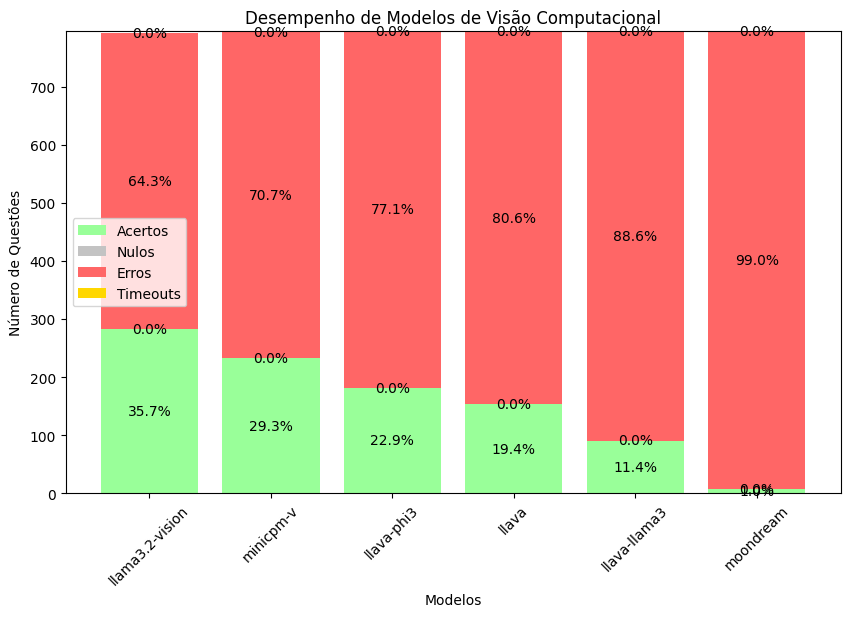

In [25]:
visions_models = ["llava", "llama3.2-vision", "llava-llama3", "minicpm-v","moondream", "llava-phi3"]

context_questions = list(filter(lambda x : x["type"] == "context-image", questoes))

# test_result_context_vision = test_models(
#     primary_models= visions_models,
#     questions = context_questions,
# )

vision_models_test_table = lib.utils.test_table(
    models=visions_models,
    questions=context_questions
)

clear_output(wait=True)
display(lib.utils.format_test_table(vision_models_test_table))
plots.model_performance(vision_models_test_table, "Desempenho de Modelos de Visão Computacional")
None

Como esperado, os resultados dos testes com imagens forma muito abaixo do esperado, com um modelo conseguindo acertar apenas 8 questões, e o modelo com maior acurácia conseguiu apenas 35.7% de acurácia. O **lava** que verificamos na etapa anterior reduziu metade de sua acurácia, chegando a apenas 19.4%, em contraste aos 40% do teste anterior, número esse que é superior ao melhor modelo de visão nesse teste.

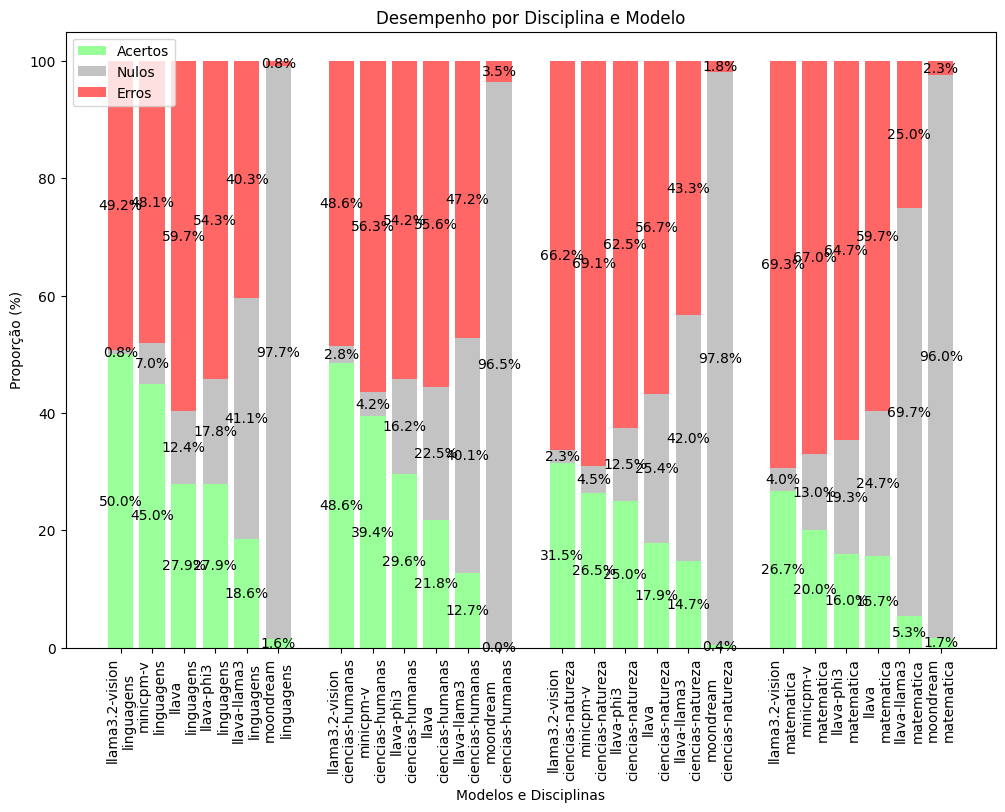

In [26]:
plots.discipline_performance(visions_models, context_questions, normalize=True)
None

Observando o desempenho por disciplina, é como se o desempenho fosse reduzido pela metade em comparação com as questões de apenas texto, porém a discrepância das disciplinas forma bem inferiores à discrepância anterior, uma vez que houve uma dificuldade em todas as questões.

### 3.2 Mesclando Modelos

Uma ideia que tivemos é tentar juntar dois modelos para tentarmos ter uma acurácia melhor, para isso nós selecionamos os melhores modelos que tivemos na etapa 2, e juntamos com todos os modelos de visão computacional, na qual o sistema funciona da seguinte maneira:

graph TD
    A[Questão com Imagem] -->|Envia Imagem| B[Modelo de Visão]
    B -->|Retorna Descrição da Imagem| C[Descrição da Imagem]
    C -->|Combina com Questão| D[Questão Completa]
    D -->|Envia para Modelo 2| E[Modelo Textual]
    E -->|Retorna Resposta| F[Resposta Final]


Ou seja, primeiramente pedimos a descrição da imagem ao modelo de visão, a partir de sua descrição, integramos a descrição na questão, e enviamos para o modelo de texto. Por fim, o modelo de texto retorna a resposta final.

Primeiramente tinhamos selecionado 25 questões de cada disciplina, de forma bastante similar como foi feito nos testes de texto, porém, com a junção de dois modelos, o tempo de execuçõ dos modelos, subiu muito, e tivemos que reduzir para 10 questões de cada disciplina.

,Model,Size,Finish,OK,Null,Err,Tout,Acc,Ttot,TTout,Tle,Tavg,Tmax,Tmin
0,minicpm-v+phi4,14.6,40 (53.3%),27,0,13,0,0.675000,15:06,45:06,04:45:11,22.66,40.36,9.49
1,llama3.2-vision+phi4,17.0,40 (53.3%),24,0,16,0,0.600000,23:29,38:29,07:23:30,35.25,55.78,11.77
2,llama3.2-vision+mistral-small,21.9,40 (53.3%),22,1,16,1,0.550000,53:05,01:08:05,16:42:06,01:19,02:50,41.08
3,minicpm-v+gemma2,10.9,40 (53.3%),22,0,18,0,0.550000,07:27,37:27,02:20:37,11.18,23.79,7.86
4,moondream+phi4,10.8,40 (53.3%),22,0,18,0,0.550000,10:58,40:58,03:27:02,16.45,31.81,8.58
5,llava-phi3+mistral-small,16.9,40 (53.3%),21,0,19,0,0.525000,35:05,01:05:05,11:02:27,52.65,02:14,14.81
6,moondream+mistral-small,15.7,40 (53.3%),21,0,19,0,0.525000,34:24,01:04:24,10:49:30,51.62,02:01,12.53
7,llava+phi4,13.8,40 (53.3%),21,0,19,0,0.525000,11:53,16:53,03:44:28,17.84,38.28,8.34
8,moondream+gemma2,7.1,40 (53.3%),21,0,19,0,0.525000,04:10,34:10,01:18:54,6.27,11.62,4.95
9,llava-llama3+phi4,14.6,40 (53.3%),21,0,19,0,0.525000,13:28,33:28,04:14:29,20.22,58.21,9.69


count    37.000000
mean      0.445300
std       0.102415
min       0.225000
25%       0.400000
50%       0.475000
75%       0.525000
max       0.675000
Name: Acc, dtype: float64

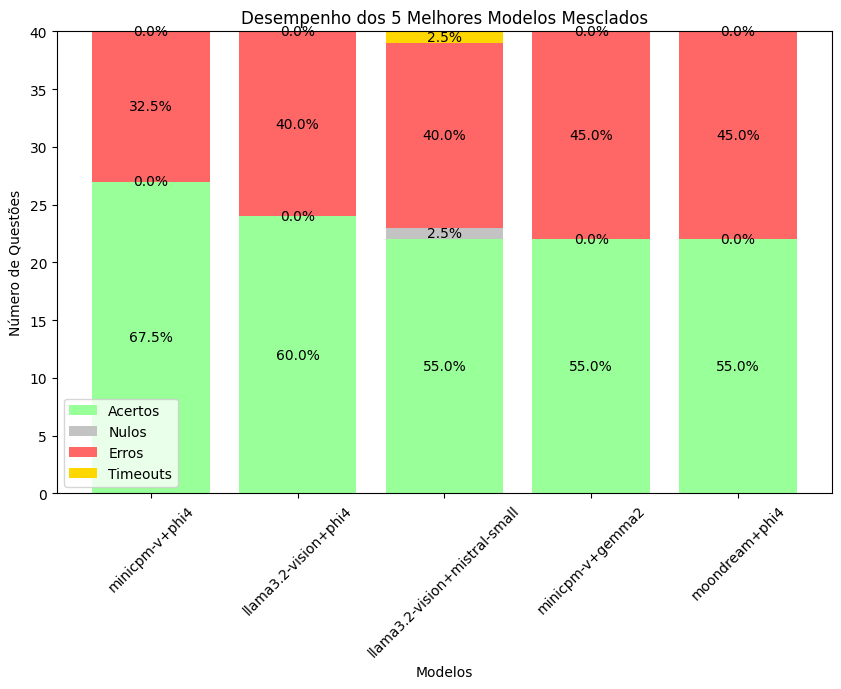

In [27]:
best_text_models = ["mistral-small", "qwen2.5:7b", "mistral-nemo", "gemma2", "mistral", "phi4"]

example_context_questions = (
    list(random.sample(list(filter(lambda x : x["discipline"] == "ciencias-humanas", context_questions)), 25))[:10] +
    list(random.sample(list(filter(lambda x : x["discipline"] == "ciencias-natureza", context_questions)),25))[:10] +
    list(random.sample(list(filter(lambda x : x["discipline"] == "linguagens", context_questions)),25))[:10] +
    list(random.sample(list(filter(lambda x : x["discipline"] == "matematica", context_questions)),25))[:10]
)

# mix_models_context_result = test_models(
#     primary_models=best_text_models,
#     secundary_models=visions_models,
#     questions=example_context_questions
# )

mix_models_test_table = lib.utils.test_table(
    models=lib.utils.gen_modelos_str(primary_models=best_text_models, secundary_models=visions_models),
    questions=context_questions
)

clear_output(wait=True)
display(lib.utils.format_test_table(mix_models_test_table))
plots.model_performance(mix_models_test_table.head(5), "Desempenho dos 5 Melhores Modelos Mesclados")

mix_models_test_table["Acc"].describe()

Em geral tivemos um desempenho muito superior ao teste com apenas modelos de visão computacional, com o 25% chegando a uma acurácia de 40. Em geral, não houve uma variação muito grande nos resultados, e a acurácia máxima que chegamos foi de 67.5%.

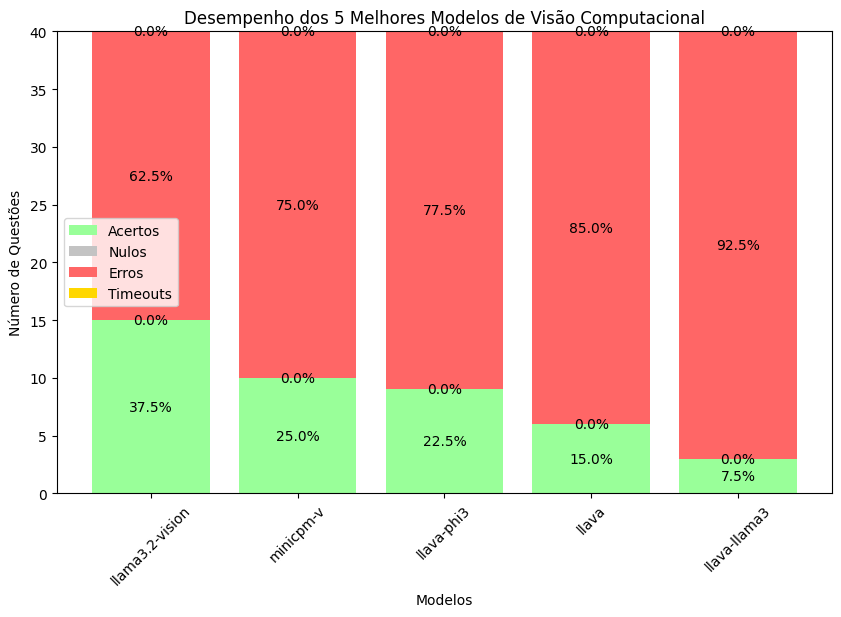

In [28]:
vision_models_test_table_example = lib.utils.test_table(
    models=visions_models,
    questions=example_context_questions
)
plots.model_performance(vision_models_test_table_example.head(5), "Desempenho dos 5 Melhores Modelos de Visão Computacional")
None

Comparando as mesmas qustões com os modelos de apenas visão computacional, nota-se que de fato, houve uma melhora significativa.

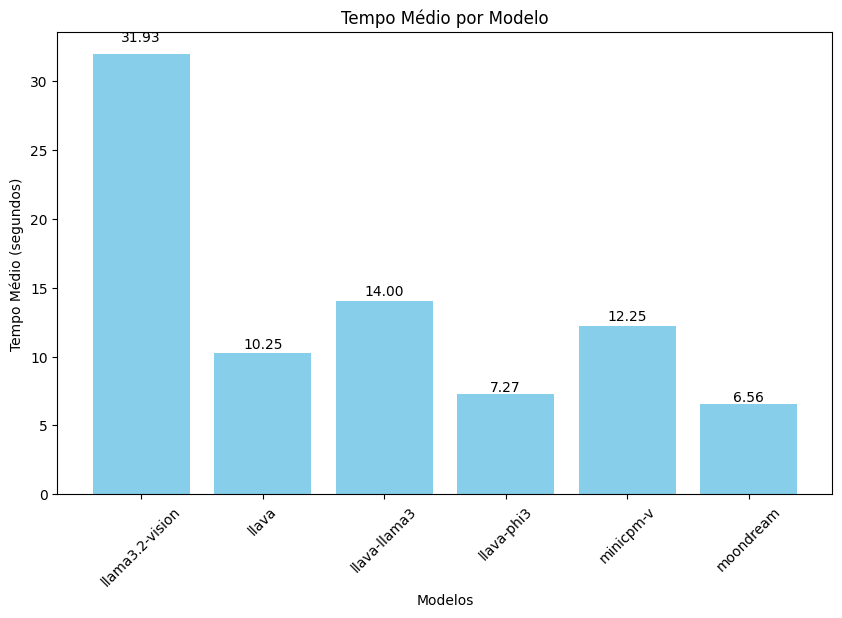

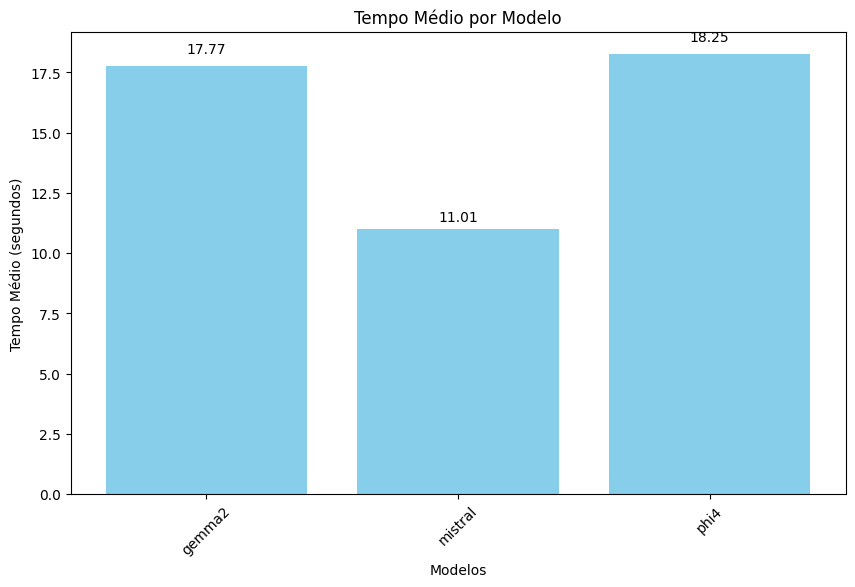

In [29]:
plots.multi_model_performance(
    group='model_vision',
    y_axis='time-avg',
    questions=example_context_questions,
    vision_models=visions_models,
    text_models=best_text_models
)

plots.multi_model_performance(
    group='model_text',
    y_axis='time-avg',
    questions=example_context_questions,
    vision_models=visions_models,
    text_models=best_text_models
)
#TODO: Ajustar o plot para acurácia e por modelo de textos

None

## 4. Questões com Imagens nas Alternativas

Temos um deafio ainda maior comparado com os anteriores, pois neste novo desafio, as alternativas estarão em formato de imagem, o que exige uma precisão maior de interpretação de como é a imagem, podendo ter questões muito complexa, primeiramente iremos explorar 2 tipos de questões presentes, e depois iremos testar com apenas modelos de visão, depois mesclaremos os modelos.


### 4.1 Exemplo de Questões 

##### Questão 21 da Prova de 2009

Os seres vivos apresentam diferentes ciclos de vida, caracterizados pelas fases nas quais gametas são produzidos e pelos processos reprodutivos que resultam na geração de novos indivíduos.

(A) |![Alternativa A](./questoes/alternative_images\2009021-A.png)

(B) |![Alternativa B](./questoes/alternative_images\2009021-B.png)

(C) |![Alternativa C](./questoes/alternative_images\2009021-C.png)

(D) |![Alternativa D](./questoes/alternative_images\2009021-D.png)

(E) | ![Alternativa E](./questoes/alternative_images\2009021-E.png)

| Resposta: C

Nessa questão notamos que a complexidade para essa questão é compreender o texto e também o diagrama, talvez o maior desafio do modelo é conseguir interpretar o funcionamento do diagrama.

##### Questão 91 da Prova de 2009

Os melhores críticos da cultura brasileira trataram-na sempre no plural, isto é, enfatizando a coexistência no Brasil de diversas culturas. Arthur Ramos distingue as culturas não europeias (indígenas, negras) das europeias (portuguesa, italiana, alemã etc.), e Darcy Ribeiro fala de diversos Brasis: crioulo, caboclo, sertanejo, caipira e de Brasis sulinos, a cada um deles correspondendo uma cultura específica.

MORAIS, F. **O Brasil na visão do artista: o país e sua cultura.**  
São Paulo: Sudameris, 2003.

(A)
![Alternativa A](./questoes/alternative_images\2009091-A.png)

(B)
![Alternativa B](./questoes/alternative_images\2009091-B.png)

(C)
![Alternativa C](./questoes/alternative_images\2009091-C.png)

(D)
![Alternativa D](./questoes/alternative_images\2009091-D.png)

(E)
![Alternativa E](./questoes/alternative_images\2009091-E.png)

| Resposta: A

Essa questão têm uma complexidade de interpretar a imagem, e ainda possui várias imagens abstratas, o que pode impactar significativamente no desempenho dos modelos, esse exemplo é bem mais complexo que o anterior.

### 4.2 Apenas Modelos de Visão

A nível de comparação, novamente iremos utilizar apenas modelos de visão computacional e avaliar o seu desempenho. Para esse teste iremos ter que remover o **ollama3.2-vision**, embora nos testes individuiais foi o melhor modelo, o modelo não suporta mais de uma imagem por requisição.

Nesse teste iremos utilizat todas as questões desse formato, pois temos apenas 61 questões

,Model,Size,Finish,OK,Null,Err,Tout,Acc,Ttot,TTout,Tle,Tavg,Tmax,Tmin
0,minicpm-v,5.5,61 (100.0%),6,0,55,0,0.098361,01:58,01:58,0.00,1.94,7.37,1.41
1,moondream,1.7,61 (100.0%),0,0,61,0,0.000000,01:08,01:08,0.00,1.12,4.57,1.02
2,llava-phi3,2.9,61 (100.0%),0,0,61,0,0.000000,03:06,03:06,0.00,3.06,11.77,2.12
3,TOTAL,10.1,183 (100.0%),6,0,177,0,0.032787,06:13,0.00,ND,2.04,11.77,1.02


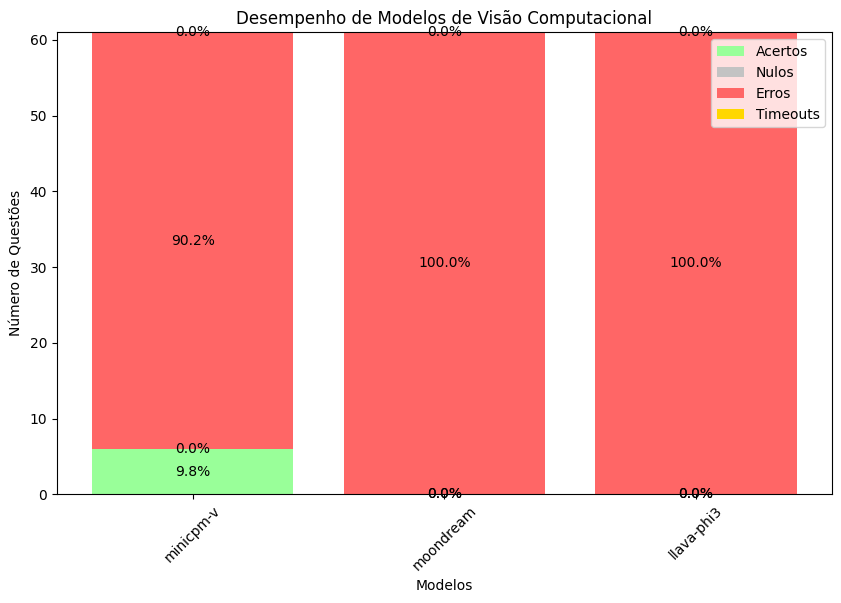

In [32]:
answer_questions = list(filter(lambda x :x['type'] == 'answer-image', questoes))

# test_models(
#     models = ["moondream", "minicpm-v", "llava-phi3"], # o llama3.2-vision não suporta mais de uma imagem
#     questions = answer_questions,
#     predict_file = "./data/predict_data/answ-vision.json"
# )

answer_questions_table_vision = lib.utils.test_table(
    questions=answer_questions,
    models= ["moondream", "minicpm-v", "llava-phi3"]
)

clear_output(wait=True)
display(lib.utils.format_test_table(answer_questions_table_vision))
plots.model_performance(answer_questions_table_vision, "Desempenho de Modelos de Visão Computacional")
None

Notamos um desempenho ainda mais baixo do que o anterior, com apenas um modelo conseguindo acertar alguma questão, e mesmo assim, não conseguindo uma acurácia de nem 10%, mostrando o quão complexo se tornou esse desafio.

### 4.3 Mistura de Modelos

Então novamente iemos utilizar o recurso que utilizamos na etapa 3, e vamos incluir outro modelo no mesmo esquema de etapa 3.2. Dessa vez iremos utilizar apenas os modelos **phi4** que entregou um melhor resultado, e **gemma2**, que conseguiu entregar um resultado satisfatório, sendo mais leve e mais rápido.


,Model,Size,Finish,OK,Null,Err,Tout,Acc,Ttot,TTout,Tle,Tavg,Tmax,Tmin
0,minicpm-v+gemma2,10.9,61 (100.0%),14,0,47,0,0.229508,01:45,01:45,0.00,1.72,8.52,0.27
1,llama3.2-vision+gemma2,13.3,61 (100.0%),11,0,50,0,0.180328,01:41,01:41,0.00,1.67,9.11,0.27
2,minicpm-v+phi4,14.6,61 (100.0%),11,0,50,0,0.180328,10:31,10:31,0.00,10.35,25.40,2.12
3,moondream+gemma2,7.1,61 (100.0%),11,0,50,0,0.180328,01:57,01:57,0.00,1.93,8.81,0.27
4,moondream+phi4,10.8,61 (100.0%),10,0,51,0,0.163934,10:52,10:52,0.00,10.69,25.77,2.56
5,llama3.2-vision+phi4,17.0,61 (100.0%),9,0,52,0,0.147541,11:17,11:17,0.00,11.10,26.76,2.26
6,TOTAL,73.7,366 (100.0%),66,0,300,0,0.180328,38:05,0.00,ND,6.24,26.76,0.27


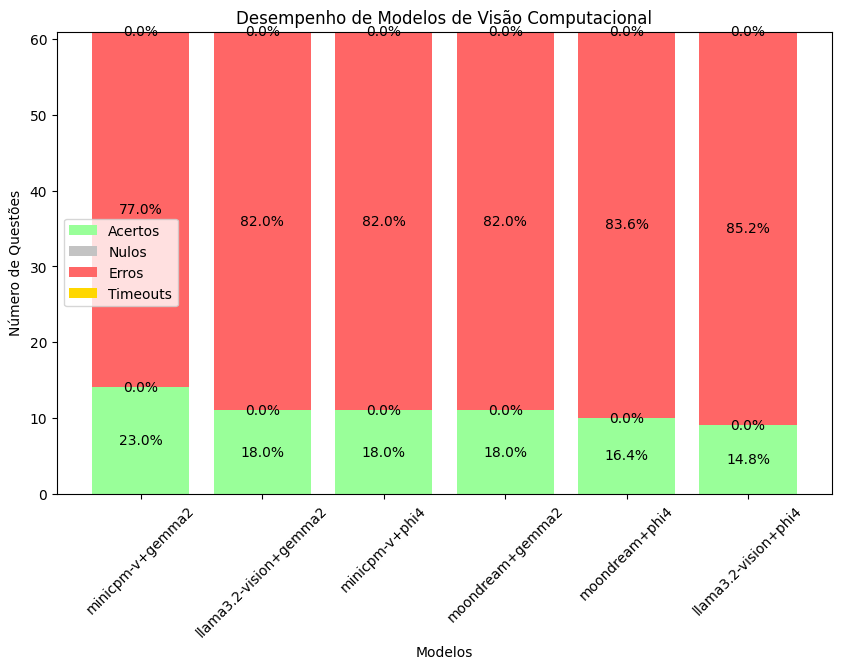

In [33]:

# test_models(
#     primary_models = ['phi4', 'gemma2'],
#     secundary_models= ["llama3.2-vision", "moondream", "minicpm-v"],
#     questions=answer_questions,
# )

answer_questions_table_mix = lib.utils.test_table(
    questions=answer_questions,
    models= lib.utils.gen_modelos_str(
        primary_models= ['phi4', 'gemma2'], 
        secundary_models= ["llama3.2-vision", "moondream", "minicpm-v"]
    )
)


clear_output(wait=True)
display(lib.utils.format_test_table(answer_questions_table_mix))
plots.model_performance(answer_questions_table_mix, "Desempenho de Modelos de Visão Computacional")
None

Conseguimos um desempenho maior, porém baixo, não chegando a nem 23% no melhor caso, a questão que apresentamos, por exemplo, nenhum modelo conseguiu, nem mesmo mesclando os modelos, eles forma capazes de acertar essa questão.

## 5. Questões com imagens no contexto e nas alternativas

Por fim, nosso último desafio, o mais complexo deles, agora devemos interpretar a imagem e as alternativas. A expectativa que tenhamos um resultado ainda mais baixo que que a forma anterior, que já foi extremamente baixa.


### 5.1 Exemplo de Questões Full-Image


Em Florença, Itália, na Igreja de Santa Croce, é possível encontrar um portão em que aparecem os anéis de Borromeo. Alguns historiadores acreditavam que os círculos representavam as três artes: escultura, pintura e arquitetura, pois elas eram tão próximas quanto inseparáveis.

![Imagem Contexto](./questoes/context_images\2009149.jpg)

(A)
![Alternativa A](./questoes/alternative_images\2009149-A.jpg)

(B)
![Alternativa B](./questoes/alternative_images\2009149-B.jpg)

(C)
![Alternativa C](./questoes/alternative_images\2009149-C.jpg)

(D)
![Alternativa D](./questoes/alternative_images\2009149-D.jpg)

(E)
![Alternativa E](./questoes/alternative_images\2009149-E.jpg)

| Resposta: E

### 5.2 Modelos de Visão

,Model,Size,Finish,OK,Null,Err,Tout,Acc,Ttot,TTout,Tle,Tavg,Tmax,Tmin
0,minicpm-v,5.5,61 (100.0%),6,0,55,0,0.098361,01:58,01:58,0.00,1.94,7.37,1.41
1,moondream,1.7,61 (100.0%),0,0,61,0,0.000000,01:08,01:08,0.00,1.12,4.57,1.02
2,llava-phi3,2.9,61 (100.0%),0,0,61,0,0.000000,03:06,03:06,0.00,3.06,11.77,2.12
3,TOTAL,10.1,183 (100.0%),6,0,177,0,0.032787,06:13,0.00,ND,2.04,11.77,1.02


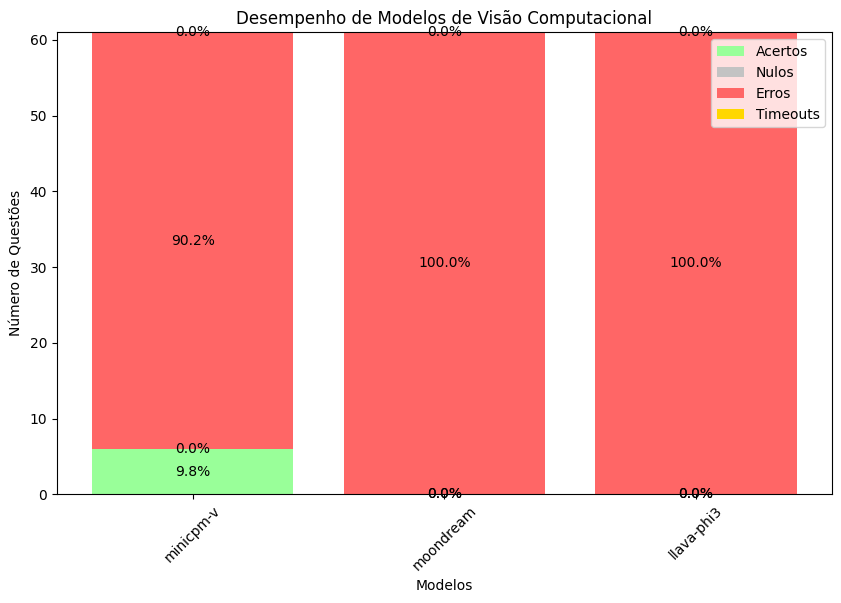

In [36]:
full_image_questions = list(filter(lambda x :x['type'] == 'full-image', questoes))

full_questions_table_vision = lib.utils.test_table(
    questions=answer_questions,
    models= ["moondream", "minicpm-v", "llava-phi3"]
)

clear_output(wait=True)
display(lib.utils.format_test_table(full_questions_table_vision))
plots.model_performance(full_questions_table_vision, "Desempenho de Modelos de Visão Computacional")
None

### 5.3 Modelos Combinados

,Model,Size,Finish,OK,Null,Err,Tout,Acc,Ttot,TTout,Tle,Tavg,Tmax,Tmin
0,minicpm-v+gemma2,10.9,61 (100.0%),14,0,47,0,0.229508,01:45,01:45,0.00,1.72,8.52,0.27
1,llama3.2-vision+gemma2,13.3,61 (100.0%),11,0,50,0,0.180328,01:41,01:41,0.00,1.67,9.11,0.27
2,minicpm-v+phi4,14.6,61 (100.0%),11,0,50,0,0.180328,10:31,10:31,0.00,10.35,25.40,2.12
3,moondream+gemma2,7.1,61 (100.0%),11,0,50,0,0.180328,01:57,01:57,0.00,1.93,8.81,0.27
4,moondream+phi4,10.8,61 (100.0%),10,0,51,0,0.163934,10:52,10:52,0.00,10.69,25.77,2.56
5,llama3.2-vision+phi4,17.0,61 (100.0%),9,0,52,0,0.147541,11:17,11:17,0.00,11.10,26.76,2.26
6,TOTAL,73.7,366 (100.0%),66,0,300,0,0.180328,38:05,0.00,ND,6.24,26.76,0.27


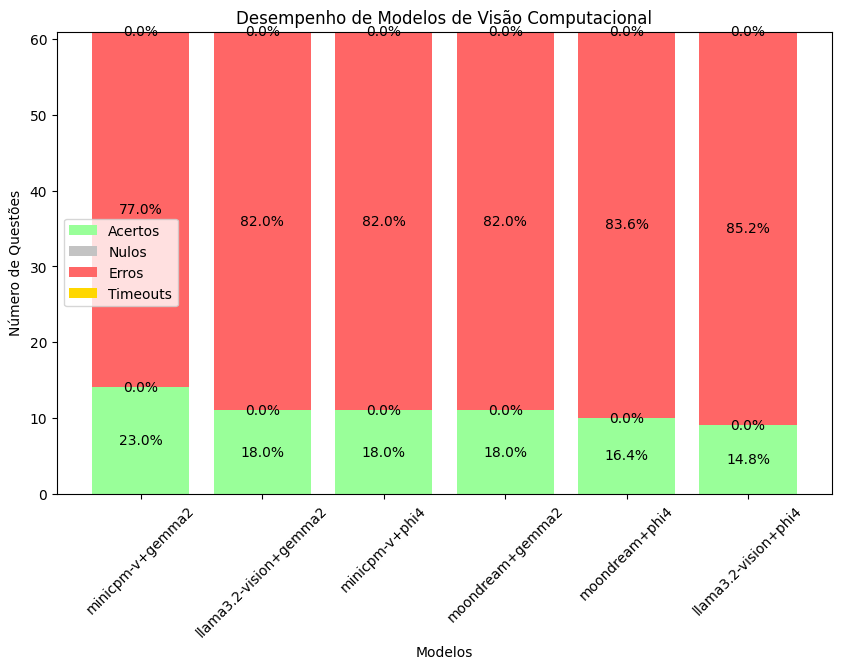

In [37]:
full_questions_table_mix = lib.utils.test_table(
    questions=answer_questions,
    models= lib.utils.gen_modelos_str(
        primary_models= ['phi4', 'gemma2'], 
        secundary_models= ["llama3.2-vision", "moondream", "minicpm-v"]
    )
)

clear_output(wait=True)
display(lib.utils.format_test_table(full_questions_table_mix))
plots.model_performance(full_questions_table_mix, "Desempenho de Modelos de Visão Computacional")
None